<a href="https://colab.research.google.com/github/veroorli/ProjetProg/blob/master/TME1_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SUJET SEUL 

Afficher le panneau latéral avec la table des matières

# BDLE TP1 IMDB avec Databricks

révision du 24-09-2021

## Préparation

Commencer par attacher le notebook à un cluster. Cela démarre les resources de calcul pour traiter les cellules du notebook. Une façon simple de démarrer un cluster est de demander à exécuter une cellule du notebook :

In [ ]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.0 
 Master 
 local[8] 
 AppName 
 Databricks Shell

On ajuste l'environnement d'exécution des requêtes à la taille du cluster (8 coeurs)

In [ ]:
# on utilise 8 partitions au lieu de 200 par défaut
spark.conf.set("spark.sql.shuffle.partitions", "8")
print("Nombre de partitions utilisées : ", spark.conf.get("spark.sql.shuffle.partitions"))

Nombre de partitions utilisées : 8

### Uploader les datasets de IMDB

In [ ]:
# URL du dossier PUBLIC_DATASET contenant des fichiers de données pour les TP
# ---------------------------------------------------------------------------
# en cas de problème avec le téléchargement des datasets, aller directement sur l'URL ci-dessous
PUBLIC_DATASET_URL = "https://nuage.lip6.fr/s/H3bpyRGgnCq2NR4" 
PUBLIC_DATASET=PUBLIC_DATASET_URL + "/download?path="

print("URL pour les datasets ", PUBLIC_DATASET_URL)

URL pour les datasets https://nuage.lip6.fr/s/H3bpyRGgnCq2NR4

Télécharger les fichiers de IMDB directement sur le cluster databricks, sans passer par votre ordinateur perso

In [ ]:
%sh
mkdir -p /temp
wget --no-verbose  https://nuage.lip6.fr/s/H3bpyRGgnCq2NR4/download?path=/imdb/vldb2015/csvfiles_sample001.tgz -O /temp/csvfiles_sample001.tgz
cd /temp && tar zxf /temp/csvfiles_sample001.tgz
ls -lh /temp

2021-09-25 09:24:20 URL:https://nuage.lip6.fr/s/H3bpyRGgnCq2NR4/download?path=/imdb/vldb2015/csvfiles_sample001.tgz [73571656/73571656] -> "/temp/csvfiles_sample001.tgz" [1]

total 71M

drwxr-xr-x 2 50077 203 4.0K Sep 12 2019 csvfiles_sample001

-rw-r--r-- 1 root root 71M Sep 25 09:24 csvfiles_sample001.tgz

Définir le nom du dossier contenant les fichiers csv de IMDB

In [ ]:
imdb_dir = "/FileStore/tables/imdb/"
print ("le dossier pour les fichiers de IMDB est:", imdb_dir)

le dossier pour les fichiers de IMDB est: /FileStore/tables/imdb/

Copier les fichiers de IMDB dans DBFS

In [ ]:
dbutils.fs.mkdirs(imdb_dir)
dbutils.fs.cp("file:/temp/csvfiles_sample001", imdb_dir, recurse=True)

True

Liste des fichiers IMDB :

In [ ]:
display(dbutils.fs.ls(imdb_dir))

path name size dbfs:/FileStore/tables/imdb/cast_info.csv cast_info.csv 15368545 dbfs:/FileStore/tables/imdb/company_name.csv company_name.csv 894637 dbfs:/FileStore/tables/imdb/company_type.csv company_type.csv 92 dbfs:/FileStore/tables/imdb/info_type.csv info_type.csv 1928 dbfs:/FileStore/tables/imdb/kind_type.csv kind_type.csv 85 dbfs:/FileStore/tables/imdb/movie_companies.csv movie_companies.csv 956556 dbfs:/FileStore/tables/imdb/movie_info.csv movie_info.csv 9854170 dbfs:/FileStore/tables/imdb/name.csv name.csv 17549614 dbfs:/FileStore/tables/imdb/person_info.csv person_info.csv 145007548 dbfs:/FileStore/tables/imdb/role_type.csv role_type.csv 160 dbfs:/FileStore/tables/imdb/title.csv title.csv 2262112

Cette étape est **FACULTATIVE**

Ne **pas** faire cette étape si vous avez déjà importé les données du TP dans votre espace de stockage Databricks.

Télécharger l'archive contenant les fichiers IMDB.
Dans PUBLIC_DATASET https://nuage.lip6.fr/s/H3bpyRGgnCq2NR4
aller dans le dossier imdb/vldb2015 et télécharger le fichier csvfiles_sample001.tgz

Lien direct :
https://nuage.lip6.fr/s/H3bpyRGgnCq2NR4/download?path=/imdb/vldb2015&files=csvfiles_sample001.tgz

Extraire les fichiers csv de l'archive

Menu Data -> Add Data
Sélectionner un nouveau dossier pour _DBFS target directory_  /FileStore/tables/**imdb**
puis uploader tous les fichiers csv dans ce directory.

## Définir les tables de la base IMDB

La table Title affecte un identifiant id à un film

In [ ]:
dir = "/FileStore/tables/imdb/"

schema_title = """
          id INT, 
          title STRING, 
          imdb_index STRING, 
          kind_id INT, 
          production_year INT, 
          imdb_id INT, 
          phonetic_code STRING, 
          episode_id STRING,
          season_nr INT, 
          episode_nr INT, 
          series_years STRING, 
          md5sum STRING
        """

title = spark.read.csv(path = dir + "title.csv", schema = schema_title).persist()
title.createOrReplaceTempView("Title")
display(title)

La table Kind_type

In [ ]:
#============
# Kind_Type
#============
schema_kind_type = "id INT, kind STRING"

kind_type = spark.read.csv(path = dir + "kind_type.csv", schema = schema_kind_type).persist()

kind_type.createOrReplaceTempView("Kind_Type")
#kind_type.printSchema()
display(kind_type)

id kind 1 movie 2 tv series 3 tv movie 4 video movie 5 tv mini series 6 video game 7 episode

La table Info_type indique la nature d'un attribut d'information. 
Sert dans Movie_Info, Person_Info

In [ ]:
#==============
# Info_Type
#==============
schema_info_type = "id INT, info STRING"

info_type = spark.read.csv(path = dir + "info_type.csv", schema = schema_info_type).persist()

info_type.createOrReplaceTempView("Info_Type")
#info_type.printSchema()

display(info_type)

id info 1 runtimes 2 color info 3 genres 4 languages 5 certificates 6 sound mix 7 tech info 8 countries 9 taglines 10 keywords 11 alternate versions 12 crazy credits 13 goofs 14 soundtrack 15 quotes 16 release dates 17 trivia 18 locations 19 mini biography 20 birth notes 21 birth date 22 height 23 death date 24 spouse 25 other works 26 birth name 27 salary history 28 nick names 29 books 30 agent address 31 biographical movies 32 portrayed in 33 where now 34 trade mark 35 interviews 36 article 37 magazine cover photo 38 pictorial 39 death notes 40 LD disc format 41 LD year 42 LD digital sound 43 LD official retail price 44 LD frequency response 45 LD pressing plant 46 LD length 47 LD language 48 LD review 49 LD spaciality 50 LD release date 51 LD production country 52 LD contrast 53 LD color rendition 54 LD picture format 55 LD video noise 56 LD video artifacts 57 LD release country 58 LD sharpness 59 LD dynamic range 60 LD audio noise 61 LD color information 62 LD group genre 63 LD quality program 64 LD close captions-teletext-ld-g 65 LD category 66 LD analog left 67 LD certification 68 LD audio quality 69 LD video quality 70 LD aspect ratio 71 LD analog right 72 LD additional information 73 LD number of chapter stops 74 LD dialogue intellegibility 75 LD disc size 76 LD master format 77 LD subtitles 78 LD status of availablility 79 LD quality of source 80 LD number of sides 81 LD video standard 82 LD supplement 83 LD original title 84 LD sound encoding 85 LD number 86 LD label 87 LD catalog number 88 LD laserdisc title 89 screenplay-teleplay 90 novel 91 adaption 92 book 93 production process protocol 94 printed media reviews 95 essays 96 other literature 97 mpaa 98 plot 99 votes distribution 100 votes 101 rating 102 production dates 103 copyright holder 104 filming dates 105 budget 106 weekend gross 107 gross 108 opening weekend 109 rentals 110 admissions 111 studios 112 top 250 rank 113 bottom 10 rank

La table Movie_info

In [ ]:
#==============
# Movie_Info
#==============
schema_movie_info = """
    id int,
    movie_id int,
    info_type_id int,
    info string,
    note string
"""

movie_info = spark.read.csv(path = dir + "movie_info.csv", schema = schema_movie_info).persist()

movie_info.createOrReplaceTempView("Movie_Info")
#movie_info.printSchema()

display(movie_info)

id movie_id info_type_id info note 11658949 13 16 Italy:29 March 2012 null 11659887 434 16 Netherlands:7 January 2013 null 11661227 1680 16 USA:11 May 2011 null 11661228 1680 16 USA:11 May 2011 null 11661771 1841 16 Spain:20 March 2005 null 11662532 2907 16 Spain:28 September 2002 null 11662603 2977 16 USA:22 August 2011 null 11663044 3228 16 USA:27 September 1997 null 214865 3228 15 Two-Tone: [watches Nanny set a yard sale box down] Yard sales! I love yard sales! Actually I hate yard sales, the pros of a yard sale are the great bargains but the cons of a yard sale are that everything is used, eww yuck::Cadpig: Two-Tone... FOCUS! null 214866 3228 15 Rolly: Anybody want a peanut?... What? It's not like I've offered you some of my food before. Okay, so it's been a while. null 214867 3228 15 Cadpig: Uh-oh! I'm having an out-of-bubble experience! null 214868 3228 15 Two-Tone: Hi, Mooch. Beautiful morning, isn't it?::Mooch: It was. I can't see it anymore! null 214869 3228 15 Two-Tone: Oh, Mooch? I just came by to say to you, I have nothing to say to you. If I had anything to say to you, I'd say it to Lucky, my date tonight at the dance.::Mooch: Say what? You always go out with me!::Two-Tone: Correction. Used to go with you, but you didn't ask me; Lucky did. null 214870 3228 15 Two-Tone: Don't hide, Lucky. I like your new look.::Lucky: No, you don't. Mooch is right. You don't want to be seen with me.::Two-Tone: Yes, I do! You're still Lucky. I think you're cool in any color.::Lucky: Really?::Two-Tone: Yeah. null 214871 3228 15 Rolly: Hey, watch where you're going, you clumsy box! null 214872 3228 15 Cadpig: No glitz, no glory. null 214873 3228 15 Lucky: The farm looks fantastic! Just looking at it makes me feel so... itchy!::Cadpig: What are you so itchy about?::Lucky: I'm itching to go to the dance with Two-Tone.::Cadpig: Someone's been bitten by the puppy love bug.::Lucky: Well, that explains why I itch... but does it explain why I hear music? null 214874 3228 15 Two-Tone: [to Mooch] I just came by here to say to you that I have nothing to say to you. If I had anything to say to you, I'd say it to Lucky... my date tonight at the dance! null 214875 3228 15 Two-Tone: Yard sales? I love yard sales! Actually, I hate yard sales. The pros of a yard sale are the bargains, but the cons of a yard sale are that the items are used! Ugh!::Cadpig: Two-Tone? Focus! null 214876 3228 15 Lucky: Where did you learn about this?::Spot: I'm Professor Egghead Science Over-Easy! null 214877 3228 15 Two-Tone: Hi, Mooch. Beautiful morning, isn't it?::Mooch: It was! I can't see it anymore! null 214878 3228 15 Lucky: I look like a big wad of bubble gum.::Rolly: Then why'd you dye yourself pink? You shoulda picked another color! null 214879 3228 15 Spot: How do you hide an elephant?::Rolly: Maybe we can put him on wheels and disguise him as a vacuum cleaner.::Spot: Or stick little magnets on him and pretend he's a refrigerator.::Cadpig: Or put a saddle on his back and pretend he's a horse with a glandular problem. null 214880 3228 15 Rolly: Anybody want some peanuts?::[the other pups give strange looks]::Rolly: What? It's not like I've never offered you any of my food before. Okay, so it's been a while. null 214881 3228 15 Cadpig: Uh-oh! I'm having and out-of-bubble experience! null 2873294 3342 2 Color null 8980758 3342 1 90 null 4162195 3342 8 USA null 11663164 3342 16 USA:September 2000 null 5486968 3342 3 Music null 14695682 3342 9 You pick 'em. We play 'em. null 7021604 3342 4 English null 11663167 3345 16 USA:23 August 2001 null 11663315 3493 16 USA:18 August 2006 null 11663365 3544 16 USA:17 September 2004 null 2873429 3981 2 Color null 8320156 3981 18 Action Concept Studios, Hürth-Kalscheuren, North Rhine - Westphalia, Germany (studio) 4162328 3981 8 Germany null 8320157 3981 18 Hürth, North Rhine - Westphalia, Germany (studio) 7021739 3981 4 German null 8320158 3981 18 North Rhine - Westphalia, Germany null 11663905 3981 16 Germany:22 October 2008 n

La table Cast_Info

In [ ]:
#==============
# Cast_Info
#==============
schema_cast_info = """
  id int,
  person_id int,
  movie_id int,
  person_role_id int,
  note string,
  nr_order int,
  role_id int
"""

cast_info = spark.read.csv(path = dir + "cast_info.csv", schema = schema_cast_info).persist()

cast_info.createOrReplaceTempView("Cast_Info")
#cast_info.printSchema()

display(cast_info)

La table Role_type

In [ ]:
#=============
# Role_Type
#=============
schema_role_type = "id INT, role STRING"

role_type = spark.read.csv(path = dir + "role_type.csv", schema = schema_role_type).persist()

role_type.createOrReplaceTempView("Role_Type")
#role_type.printSchema()

display(role_type)

id role 1 actor 2 actress 3 producer 4 writer 5 cinematographer 6 composer 7 costume designer 8 director 9 editor 10 miscellaneous crew 11 production designer 12 guest

La table Name affecte un identifiant id à une personne

In [ ]:
#==============
# Name 
#==============
schema_name = """
  id int,
  name string,
  imdb_index string,
  imdb_id int,
  gender string,
  name_pcode_cf string,
  name_pcode_nf string,
  surname_pcode string,
  md5sum string
"""

name = spark.read.csv(path = dir + "name.csv", schema = schema_name).persist()

name.createOrReplaceTempView("Name")
#name.printSchema()

display(name)

La table Person_Info

In [ ]:
#==============
# Person_Info
#==============
schema_person_info = """
  id int,
  person_id int,
  info_type_id int,
  info string,
  note string
"""

person_info = spark.read.csv(path = dir + "person_info.csv", schema = schema_person_info).persist()
person_info.createOrReplaceTempView("Person_Info")

display(person_info)

La table Movie_Companies

In [ ]:
#==============
# Movie_Companies
#==============
schema_movie_companies = """
    id int,
    movie_id int,
    company_id int,
    company_type_id int,
    note string
"""

movie_companies = spark.read.csv(path = dir + "movie_companies.csv", schema = schema_movie_companies).persist()

movie_companies.createOrReplaceTempView("Movie_Companies")
#movie_companies.printSchema()

display(movie_companies)

La table Company_Name

In [ ]:
schema_company_name = """
    id int,
    name string,
    country_code string,
    imdb_id int,
    name_pcode_nf string,
    name_pcode_sf string,
    md5sum string
"""

company_name = spark.read.csv(path = dir + "company_name.csv", schema = schema_company_name)
company_name.createOrReplaceTempView("Company_Name")
#company_name.printSchema()

display(company_name)

La table Company_type

In [ ]:
#==============
# Company_Type
#==============
schema_company_type = "id INT, kind STRING"

company_type = spark.read.csv(path = dir + "company_type.csv", schema = schema_company_type).persist()
company_type.createOrReplaceTempView("Company_Type")
#company_type.printSchema()

display(company_type)

id kind 1 distributors 2 production companies 3 special effects companies 4 miscellaneous companies

## Exemples de requêtes

Rmq : dans une cellule de code, possibilité de faire _Run All Above_ pour traiter toutes les cellules précédentes.

### Requêtes sur les films : fichier title

In [ ]:
%sql
select *
from title

#### Nombre de films

In [ ]:
%sql
select count(*) as nbFilms 
from Title

nbFilms 25084

#### Les types de films

In [ ]:
%sql
select distinct kind_id 
from Title 
order by kind_id

kind_id 1 2 3 4 6 7

#### Nombre de films par type de film

In [ ]:
%sql
select kind_id, count(*) as nb 
from Title 
group by kind_id 
order by nb desc

kind_id nb 7 15274 1 6602 4 1175 3 979 2 925 6 129

#### Nombre de film par années

In [ ]:
%sql
select production_year, count(*) as nbFilms
from Title
where production_year is not null
group by production_year
order by nbFilms desc

production_year nbFilms 2012 1605 2011 1517 2010 1467 2009 1301 2008 1192 2007 1186 2006 1033 2005 948 2004 854 2003 676 2013 658 2002 581 2001 573 2000 543 1999 506 1998 452 1997 395 1995 358 1996 354 1994 305 1993 275 1992 265 1990 259 1991 231 1987 222 1988 206 1989 189 1986 182 1985 163 1969 160 1970 158 1979 158 1976 154 1978 153 1968 153 1971 150 1973 149 1972 148 1975 145 1980 145 1984 144 1983 142 1977 141 1981 140 1974 140 1982 137 1967 137 1966 130 1965 128 1962 122 1960 120 1959 118 1964 114 1961 103 1963 98 1957 97 1958 84 1913 83 1955 78 1912 76 1915 75 1952 74 1956 73 1914 72 1916 68 1954 65 1953 58 1950 52 1911 52 1910 47 1918 45 1949 42 1917 42 1938 40 1919 40 1951 39 1937 37 1929 36 1920 36 1922 35 1940 33 1936 32 1921 31 1935 28 1923 28 1928 27 1933 27 1926 26 1939 26 1931 26 1948 26 2014 26 1909 25 1941 25 1899 24 1944 22 1901 22 1942 22 1934 21 1927 21 1932 21 1930 21 1925 21 1908 20 1907 20 1946 19 1947 19 1898 19 1924 18 1943 18 1903 18 1897 17 1902 15 1900 14 1896 13 1945 13 1905 11 1906 9 1904 9 2015 4 1895 1 2016 1

#### Distribution d'un attribut avec describe()

In [ ]:
filmPerYear = spark.sql("""
select production_year, count(*) as nb
from Title
where production_year is not null
group by production_year
order by nb desc
""")

description = filmPerYear.describe('nb')
display(description)

summary nb count 122 mean 199.7377049180328 stddev 331.00849663956 min 1 max 1605

#### Visualiser le nombre de films par années

[Documentation MatplotLib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.html#module-matplotlib.pyplot)

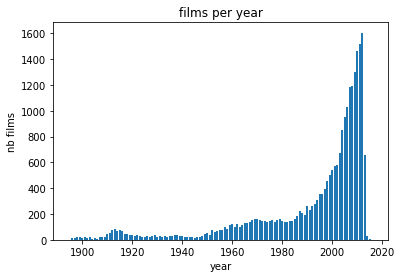

In [ ]:
import matplotlib.pyplot as plt

t = filmPerYear.collect()

tabYear = [x.production_year for x in t]
tabNb = [x.nb for x in t]

plt.bar(tabYear, tabNb)
plt.xlabel('year')
plt.ylabel('nb films')
plt.title('films per year')
plt.show()

### Requêtes sur les types de films : kind_type

In [ ]:
%sql
SELECT * 
FROM Kind_type

id kind 1 movie 2 tv series 3 tv movie 4 video movie 5 tv mini series 6 video game 7 episode

#### Jointure entre Title et Kind_Type

In [ ]:
title.printSchema()

root
-- id: integer (nullable = true)
-- title: string (nullable = true)
-- imdb_index: string (nullable = true)
-- kind_id: integer (nullable = true)
-- production_year: integer (nullable = true)
-- imdb_id: integer (nullable = true)
-- phonetic_code: string (nullable = true)
-- episode_id: string (nullable = true)
-- season_nr: integer (nullable = true)
-- episode_nr: integer (nullable = true)
-- series_years: string (nullable = true)
-- md5sum: string (nullable = true)

In [ ]:
%sql
SELECT k.kind, t.title, t.production_year 
FROM Title t, Kind_Type k 
WHERE t.kind_id = k.id
ORDER BY t.production_year DESC

kind title production_year movie Star Trek 3 2016 movie The Bonus Army 2015 movie The Smoker 2015 movie Hundred Degrees in the Shade 2015 movie Arclight 2015 movie Bad Boys Crazy Girls 2014 movie Left Behind 2014 tv movie Once Upon a Time in Beverly Hills 2014 tv series Witness Protection: Return of the Prophet 2014 movie 6 Days Watching 2014 movie Need for Speed 2014 movie One Moment Please... 2014 movie Cockroaches 2014 movie Racer's Heart 2014 movie Pimp Down 2014 movie Playin' for Love 2014 movie Brothers Day 2014 movie Skin 2014 movie Bright Ideas 2014 movie The Long Midnight of Barney Thomson 2014 movie The Final Solution 2014 movie 3 Solitude 2014 movie The Last Showing 2014 movie Devil's Tree 2014 movie The Valiant 2014 movie Dead by Dawn 2014 movie Totta 2014 movie The Snakehead 2014 movie Thug-Ocracy 2014 movie Frank 2014 movie Wings 2014 episode The Stranger You Know 2013 episode Philippe 2013 episode (#3.1) 2013 episode Yumiko Matsuoka, Rieko Akatsuka & Yukiko Kuroiwa 2013 episode Drunk & Disorderly 2013 episode (2013-02-07) 2013 episode Cast of 'Beautiful Creatures'/Gavin DeGraw/Colbie Caillat/Jermaine Dupri 2013 episode Blood Money 2013 tv series Aquí está Mirtha Medina 2013 episode Deadly Payout 2013 episode Konoucha ni hitori, Ôsaka okan ga iru! 2013 episode ActorsE Chat with Raven Blair Davis and Brett Walkow 2013 episode (#1.15) 2013 episode (#22.1) 2013 episode Bruins vs. Rangers 2013 episode Young Stars Week 2013 episode (2013-02-13) 2013 episode (2013-04-27) 2013 tv series Cesar Millan's Leader of the Pack 2013 episode (2013-01-21) 2013 episode Truth and Reconcilliation 2013 episode Prepared, Not Scared 2013 episode Mother of Invention 2013 tv series Beautiful You HDTV 2013 episode (2013-02-15) 2013 episode Every Silver Lining 2013 episode (2013-03-20) 2013 episode (#8.34) 2013 episode Week 8: Trio Dance 2013 episode Howie's Allergy/Figure Fight 2013 episode (2013-02-01) 2013 episode Attack in Algeria/40 Million Mistakes/Lincoln 2013 episode The Swag Surfer and the Cyberstalker 2013 episode (2013-05-27) 2013 episode Perfectly Perfect Boobs 2013 episode Feminine Touch 2013 episode (2013-04-02) 2013 episode Los secuestraron 2013 episode (2013-05-11) 2013 episode The Austrian Wirsthaus 2013 episode Stand Up Needlepoint 2013 episode Pranksters 2013 episode New Best Friend 2013 tv series Don't Drive Here 2013 episode (#4.6) 2013 episode (2013-03-12) 2013 episode Het weeskind 2013 tv series Matador 2013 episode Be Sweet to Your Waistline 2013 episode (2013-04-05) 2013 episode Dan Vs. The Family Cruise 2013 episode (#1.6) 2013 episode (#1.12064) 2013 episode (2013-01-02) 2013 tv series Dansai Bunri No Crime Edge 2013 episode (2013-04-08) 2013 episode Horizonte de sucesos 2013 episode Cliff Collapse 2013 episode Meeting: Part 1 2013 episode Angebote 2013 episode (2013-05-07) 2013 episode Cleveland Culture Display IU 2013 episode (#1.3) 2013 episode Get Back on the Healthy Wagon 2013 tv series Eve of Destruction 2013 episode Schweigen ist Kupfer 2013 episode Picnic 2013 episode (2013-04-21) 2013 tv series Frenemies 2013 episode One Percent 2013 episode (#1.6) 2013 episode (2013-01-04) 2013 episode Talon Reid 2013 episode (2013-02-27) 2013 episode The Crucible 2013 episode (#1.5) 2013 tv series Flat3 2013 episode Bringing Sexy Back 2013 episode Taking Comedy to the Next Level 2013 episode Credit Where Credit Is Due 2013 tv series Famewhore 2013 episode Elephant in the Room 2013 episode Lion's Den 2013 episode Kung Foolishness: Part 2 2013 episode (2013-03-02) 2013 episode Azores: Eduardo Reis 2013 episode ¡Se confesó! 2013 episode (2013-01-12) 2013 episode (2013-05-10) 2013 episode America's Breathiest Singer? 2013 episode The Real MacGyver 2013 episode Brace for Impact 2013 episode Kamandi at Earth's End #3 2013 episode (#1.65) 2013 episode (2013-05-06) 2013 episode (#2.4) 2013 episode (#1.270) 2013 episode (2013-02-27) 2013 episode Ed Begley Jr. 2013 episode (#17.87) 2013 episode The Other Woman 2013 movie Ayios 2

#### Nombre de films par type

In [ ]:
%sql
SELECT k.kind, count(*) as nb
FROM Title t, Kind_Type k 
WHERE t.kind_id = k.id
GROUP BY k.kind
ORDER BY count(*) DESC

kind nb episode 15274 movie 6602 video movie 1175 tv movie 979 tv series 925 video game 129

### Requêtes sur les rôles : cast_info

#### Une personne a un ou plusieurs roles dans un film

In [ ]:
cast_info.printSchema()

root
-- id: integer (nullable = true)
-- person_id: integer (nullable = true)
-- movie_id: integer (nullable = true)
-- person_role_id: integer (nullable = true)
-- note: string (nullable = true)
-- nr_order: integer (nullable = true)
-- role_id: integer (nullable = true)

In [ ]:
cast_info.count()

360035

#### Nombre de roles par personne

In [ ]:
res2 = spark.sql("""

select person_id, count(*) as nbRoles
from Cast_Info
group by person_id
order by nbRoles desc

""")
res2.persist()
res2.show(5)

+---------+-------+
person_id|nbRoles|
+---------+-------+
 175411| 120|
 95397| 118|
 515315| 108|
 1495180| 105|
 677696| 90|
+---------+-------+
only showing top 5 rows

descrire la distribution de l'attribut nbRoles

In [ ]:
d = res2.describe('nbRoles')
d.show()

+-------+------------------+
summary| nbRoles|
+-------+------------------+
 count| 214749|
 mean|1.6765386567574239|
 stddev|1.9565121381308854|
 min| 1|
 max| 120|
+-------+------------------+

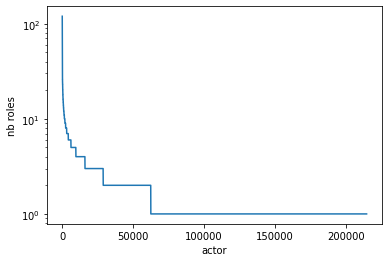

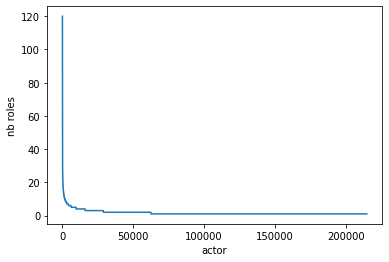

In [ ]:
#t2 = res2.sample(0.01).collect()
t2 = res2.collect()

tabNb = [x.nbRoles for x in t2]

plt.yscale('log')
plt.plot(tabNb) 
plt.xlabel('actor')
plt.ylabel('nb roles')

#plt.hist(tabNb)
plt.show()

plt.yscale('linear')
plt.plot(tabNb) 
plt.xlabel('actor')
plt.ylabel('nb roles')

plt.show()

#### Le nombre de rôles par type de film depuis 2010

In [ ]:
res3 = spark.sql("""
SELECT g.kind, count(*) as nb_roles
FROM Cast_Info c, Title f, Kind_type g
WHERE c.movie_id = f.id AND f.kind_id = g.id
AND f.production_year > 2010
GROUP BY g.kind
ORDER BY nb_roles desc
""")
res3.show(5)

+-----------+--------+
 kind|nb_roles|
+-----------+--------+
 episode| 36527|
 movie| 15897|
 tv movie| 1842|
video movie| 1421|
 tv series| 943|
+-----------+--------+
only showing top 5 rows

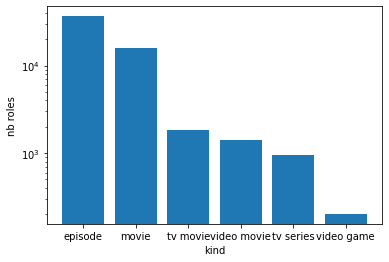

In [ ]:
t3 = res3.collect()

tabNb = [x.nb_roles for x in t3]
tabKind = [x.kind for x in t3]

plt.yscale('log')
plt.bar(tabKind,tabNb) 
plt.xlabel('kind')
plt.ylabel('nb roles')

#plt.hist(tabNb)

plt.show()

## Autres traitements

### Extraction de la date de sortie _release_dates_

In [ ]:
%sql
create or replace temp view TitleDetail as
select t.id, t.title, t.production_year, k.kind, it.info as property, m.info as value
from Title t, Movie_Info m, Info_type it, Kind_Type k
where t.id = m.movie_id 
and m.info_type_id = it.id
and t.kind_id = k.id
;

select * 
from TitleDetail t
order by  t.production_year desc, t.title
limit 100;

id title production_year kind property value 2310404 Star Trek 3 2016 movie genres Action 2310404 Star Trek 3 2016 movie countries USA 2310404 Star Trek 3 2016 movie color info Color 2310404 Star Trek 3 2016 movie genres Adventure 2310404 Star Trek 3 2016 movie release dates USA:2016 2310404 Star Trek 3 2016 movie languages English 2310404 Star Trek 3 2016 movie genres Sci-Fi 1694099 Arclight 2015 movie countries USA 1694099 Arclight 2015 movie genres Sci-Fi 1963857 Hundred Degrees in the Shade 2015 movie genres Comedy 1963857 Hundred Degrees in the Shade 2015 movie plot Thirty years after castrating the manhood of his redneck-ridden Alabama hometown by deliberately throwing the high school championship football game, Whit returns home. On the run after a painful divorce, he accidentally rediscovers a bit about himself and rekindles the relationship with his aging father, Pap. 1963857 Hundred Degrees in the Shade 2015 movie countries USA 1963857 Hundred Degrees in the Shade 2015 movie genres Romance 1963857 Hundred Degrees in the Shade 2015 movie genres Drama 2351456 The Bonus Army 2015 movie plot The true story of a nonviolent protest march from Portland, OR on Washington by World War I veterans during the Great Depression. The machinations of several persons including J. Edgar Hoover, Gen. Douglas MacArthur, and members of the American Communist Party lead to a situation in which the government deployed troops against its own countrymen, killing 4 individuals. The public backlash against Herbert Hoover led to the election of FDR, the era of the New Deal, and eventual passage of the Bonus Bill. 2351456 The Bonus Army 2015 movie release dates USA:2015 2351456 The Bonus Army 2015 movie genres Drama 2351456 The Bonus Army 2015 movie plot The true story of a nonviolent protest march from Portland, OR on Washington by World War I veterans during the Great Depression. The machinations of several persons including J. Edgar Hoover, Gen. Douglas MacArthur, and members of the American Communist Party lead to a situation in which the government deployed troops against its own countrymen, killing 4 individuals. The public backlash against Herbert Hoover led to the election of FDR, the era of the New Deal, and eventual passage of the Bonus Bill. 2351456 The Bonus Army 2015 movie genres History 2351456 The Bonus Army 2015 movie locations Harrisburg, Pennsylvania, USA 2351456 The Bonus Army 2015 movie locations Portland, Oregon, USA 2351456 The Bonus Army 2015 movie countries USA 2414180 The Smoker 2015 movie languages English 2414180 The Smoker 2015 movie genres Comedy 2414180 The Smoker 2015 movie genres Romance 2414180 The Smoker 2015 movie plot An English teacher at a prestigious all-girls school is invited to dinner at the home of one of his students. A beautiful senior in his class has decided that he would be the perfect husband for her -- not because she's in love with him but because she thinks they would be a good match. The idea is supported by her eccentric parents, who encourage them to get married. 2414180 The Smoker 2015 movie color info Color 2414180 The Smoker 2015 movie countries USA 2414180 The Smoker 2015 movie release dates USA:2015 1640310 3 Solitude 2014 movie languages English 1640310 3 Solitude 2014 movie taglines The mind will do what you tell it. 1640310 3 Solitude 2014 movie genres Action 1640310 3 Solitude 2014 movie genres Drama 1640310 3 Solitude 2014 movie genres Thriller 1640310 3 Solitude 2014 movie release dates USA:2014 1640310 3 Solitude 2014 movie locations Baton Rouge, Louisiana, USA 1640310 3 Solitude 2014 movie countries USA 1640310 3 Solitude 2014 movie copyright holder 3 Solitude LLC 1640310 3 Solitude 2014 movie budget $6,000,000 1640310 3 Solitude 2014 movie runtimes 100 1640310 3 Solitude 2014 movie genres Horror 1640310 3 Solitude 2014 movie color info Color 1642456 6 Days Watching 2014 movie countries USA 1642456 6 Days Watching 2014 movie plot An offer to make some money and (temporarily)live

Mémoriser le résultat de TitleDetail pour éviter de le calculer plusieurs fois

In [ ]:
%sql
cache table TitleDetail

Une oeuvre peut avoir les propriétés suivantes

#### Informations détaillées sur toutes les propriétés d'une personne

In [ ]:
%sql
create or replace temp view NameDetail as
select n.id, n.name, n.gender, i.info as property, p.info as value
from Name n, Person_Info p, Info_type i
where n.id = p.person_id
and p.info_type_id = i.id
;
 
select * 
from NameDetail n
where n.name like 'Smi%'
order by n.name, n.property
limit 100;

id name gender property value 2544489 Smid, Coosje f trivia Daughter of 'Ernst Daniël Smid' (qv) and Rosemarie Giesen van der Sluis. 1454381 Smid, Ernst Daniël m birth date 6 May 1953 1454381 Smid, Ernst Daniël m birth notes Enschede, Overijssel, Netherlands 1454381 Smid, Ernst Daniël m magazine cover photo "Ncrv Gids" (Netherlands), 17 April 1999, Iss. 16 1454381 Smid, Ernst Daniël m other works Provided the voice of Ocious P. Potter in the Dutch version of _The Borrowers (1997)_ (qv). 1454381 Smid, Ernst Daniël m other works Provided the voice of Gouverneur Ratcliffe in the Dutch version of _Pocahontas (1995)_ (qv). 1454381 Smid, Ernst Daniël m other works Provided the voice of Generaal in the Dutch version of _Thunderpants (2002)_ (qv). 1454381 Smid, Ernst Daniël m other works Provided the voice of Alameda Slim in the Dutch version of _Home on the Range (2004)_ (qv). 1454381 Smid, Ernst Daniël m other works Provided the voice of Clayton in the Dutch version of _Tarzan (1999)_ (qv). 1454381 Smid, Ernst Daniël m other works Provided the singing voice of Frollo in the Dutch version of _The Hunchback of Notre Dame (1996)_ (qv). 1454381 Smid, Ernst Daniël m other works Provided the voice of Gouverneur Ratcliffe in the Dutch version of _Pocahontas II: Journey to a New World (1998) (V)_ (qv). 1454381 Smid, Ernst Daniël m other works Provided the singing voice of Raspoetin in the Dutch version of _Anastasia (1997)_ (qv). 1454381 Smid, Ernst Daniël m other works Provided the voice of Thunder-Karlsson (Donderkarel) in the Dutch version of _Pippi Longstocking (1997)_ (qv). 1454381 Smid, Ernst Daniël m spouse 'Rosemarie Giesen van der Sluis' (? - 13 September 2012) (her death); 1 child 1454381 Smid, Ernst Daniël m spouse 'Regina Smid' (1974 - ?) (divorced); 2 children 1454381 Smid, Ernst Daniël m trivia Daughter 'Coosje Smid' (qv) with wife Rosemarie ("Roos"). 1454381 Smid, Ernst Daniël m trivia Daughter Lieneke and son Geert with ex-wife Regina. 1454430 Smigel, Robert m article "The New York Observer" (USA), 20 October 2003, Vol. 17, Iss. 40, pg. 1+19+21, by: Frank DiGiacomo, "Triumph Sniffs a Hit: Rbert Smigel's Hump-Happy Triumph the Insult Comic Dog Has Floored MTV, Eminem, Bob Barker and Milton Berle; Priapic Puppet on Verge of Big Time: Movies, Music, Vegas Act" 1454430 Smigel, Robert m birth date 7 February 1960 1454430 Smigel, Robert m birth name Smigel, Robert M. 1454430 Smigel, Robert m birth notes New York City, New York, USA 1454430 Smigel, Robert m height 6' 0" 1454430 Smigel, Robert m interviews "TV Guide" (USA), 22 August 2004, Vol. 52, Iss. 34, pg. 10, by: Tim Williams, "Insider Q&A: Triumph" 1454430 Smigel, Robert m other works (1991) Unsold pilot: Wrote (w/'Conan O'Brien' (qv)) a pilot for a series to star 'Adam West (I)' (qv) called "Lockwell" about a washed-up TV actor who believes that he can solve crimes in real life. 1454430 Smigel, Robert m other works (2010) Wrote the introduction for "The Complete Peanuts: 1975 to 1976" by 'Charles M. Schulz' (qv), Seattle, WA: Fantagraphics Books, ISBN 1-60699-345-3 1454430 Smigel, Robert m other works (2003) Album (as Triumph the Insult Comic Dog): "Come Poop with Me" (Warner Bros. Records) 1454430 Smigel, Robert m other works (????) Music video: Appeared in 'Eminem' (qv)'s video "Ass Like That". 1454430 Smigel, Robert m spouse 'Michelle Saks Smigel' (qv) (? - present); 3 children 1454430 Smigel, Robert m trade mark Voices dog with a Hungarian accent; ie. Triumph the Insult Comic Dog 1454430 Smigel, Robert m trivia Born on the same day as 'James Spader' (qv). 1454430 Smigel, Robert m trivia Longest-running writer on _"Saturday Night Live" (1975)_ (qv); he's been writing for the show since 1985. 1454430 Smigel, Robert m trivia Infamous for making TV Funhouse segments on _"Saturday Night Live" (1975)_ (qv) like "The Ambigously Gay Duo," "The New Adventures Of Mr. T," "Michael Jackson," and the now banned "Conspiracy Theory Rock" (What if real life companies buy out other compa

Mémoriser le résultat de NameDetail pour éviter de le calculer plusieurs fois

In [ ]:
%sql
cache table NameDetail;

Une personne peut avoir les propriétés suivantes

#### Structurer la date de sortie d'un film
sélection des infos sur la date de sortie

In [ ]:
%sql
create or replace temp view Release_Date as
select t1.id, t1.title, t1.value as release_date
from TitleDetail t1
where t1.property = "release dates";

select * from Release_Date limit 3;

id title release_date 13 Intro: By My Side Italy:29 March 2012 434 Brand in Mokum Netherlands:7 January 2013 1680 A Tiny Problem in the Kitchen USA:11 May 2011

découper la chaine _release_date_  pour séparer  le pays et la date

In [ ]:
%sql
create or replace temp view SplitDate as 
select r.id, r.title, split(release_date, ':') as splitDate
from Release_Date r;

select *  from SplitDate s limit 3;

id title splitDate 13 Intro: By My Side List(Italy, 29 March 2012) 434 Brand in Mokum List(Netherlands, 7 January 2013) 1680 A Tiny Problem in the Kitchen List(USA, 11 May 2011)

In [ ]:
%sql
create or replace temp view CountryDMY as 
select s.id, s.title, element_at(s.splitDate, 1) as country, split(element_at(s.splitDate, 2),' ') as DMY
from SplitDate s
;

select * from  CountryDMY limit 3;

id title country DMY 13 Intro: By My Side Italy List(29, March, 2012) 434 Brand in Mokum Netherlands List(7, January, 2013) 1680 A Tiny Problem in the Kitchen USA List(11, May, 2011)

extraire les attributs : day, month, year

In [ ]:
%sql
-- à compléter
create or replace temp view ExtractDate as
select c.id, c.title, c.country, element_at(c.DMY, 1) as Day, element_at(c.DMY, 2) as Month, element_at(c.DMY, 3) as Year
from CountryDMY c
;

select * from ExtractDate limit 3;

id title country Day Month Year 13 Intro: By My Side Italy 29 March 2012 434 Brand in Mokum Netherlands 7 January 2013 1680 A Tiny Problem in the Kitchen USA 11 May 2011

### Diverses requêtes

#### Exemple de jointure naturelle vs. jointure externe

Jointure naturelle: Seulement les films possédant la propriété _color info_

In [ ]:
%sql
-- on sait que la référence info_type_id vaut 2 pour 'color info' dans Movie_Info

select t.id, t.title, m.info as color_info
from Title t, Movie_Info m
where t.id = m.movie_id 
and m.info_type_id = 2
order by id
limit 5;

id title color_info 54 Easy, Writer Color 160 Mystic, CT Color 296 Camp Dance Color 358 The Great Un-Escape Color 614 Dream Weaver Color

#### Questions diverses
Quels sont tous les noms d'attributs en rapport avec une date ?

In [ ]:
%sql
select *
from Info_type t
where t.info like '%date%'

id info 16 release dates 21 birth date 23 death date 50 LD release date 102 production dates 104 filming dates

Quelle est la syntaxe de la fonction **if** dans la clause select ?

In [ ]:
%sql
select n.name, n.gender, if(gender='m', 'Mr' , if(gender='f', 'Mme', 'Inconnue' )) as civilite
from Name n
where name like '%isa';

name gender civilite Bacic, Ljubisa m Mr Georgijevski, Ljubisa m Mr Hattori, Katsuhisa m Mr Ishikawa, Mitsuhisa m Mr Morikawa, Tokihisa m Mr Pavic, Sinisa m Mr Sakurada, Munehisa m Mr Stosic, Ljubisa m Mr Suzuki, Tatsuhisa m Mr Trajkovski, Ljubisa m Mr Yamashita, Tomohisa m Mr Aaron, Lisa f Mme Abernathy, Louisa f Mme Adler, Lisa f Mme Akimof, Liisa f Mme Alpert, Lisa f Mme Anna-Lisa f Mme Be, Lisa f Mme Bencivenni, Lisa f Mme Beverly, Lisa f Mme Bowerman, Lisa f Mme Bradshaw-White, Luisa f Mme Brawn, Lisa f Mme Capperino, Lisa f Mme Carlstedt, Sirkka-Liisa f Mme Carville, Lisa f Mme Cheng, Ronalisa f Mme Cipriani, Lisa f Mme D'Amato, Lisa f Mme Davis, Eisa f Mme De Leeuw, Lisa f Mme Dennis, Atty. Lisa f Mme DeRosa, Lisa f Mme Diaz, Eloisa f Mme Donaldson, Lisa f Mme Dwan, Lisa f Mme Elio, María Luisa f Mme Faulkner, Lisa f Mme Flores, María Luisa f Mme Gavasa, Luisa f Mme Gembora, Louisa f Mme Gilliam, Marisa f Mme Glass, Lisa f Mme Gossels, Lisa f Mme Hannigan, Lisa f Mme Hartman, Lisa f Mme Hayson-Phillips, Lisa f Mme Herstad, Lisa f Mme Hoover, Lisa f Mme Hwang, Lisa f Mme Hylton-Brim, Misa f Mme Håkansson, Lovisa f Mme Ingrassia, Lisa f Mme Kelly, Jean Louisa f Mme Klink, Lisa f Mme Kreuzer, Lisa f Mme Kudrow, Lisa f Mme Lacroix, Louisa f Mme Laguna, Elisa f Mme Lamata, María Luisa f Mme Laukka, Inga-Liisa f Mme Lennox, Lisa f Mme Linnertorp, Lisa f Mme London, Lisa f Mme Longo, Malisa f Mme Lovett-Mann, Lisa f Mme Mainardi, Elisa f Mme Mallet, Lisa f Mme Marton, Maija-Liisa f Mme Meisenheimer, Larisa f Mme Melendez, Lisa f Mme Miller, Lisa f Mme Miller, Marisa f Mme Milwood-Haigh, Louisa f Mme Mitchell, Lisa f Mme Mothersbaugh, Lisa f Mme Naranjo, Marisa f Mme Nilsson, Lisa f Mme Paatso, Liisa f Mme Paniagua, Marisa f Mme Parsons, Lisa f Mme Petroro, Marisa f Mme Piispanen, Elisa f Mme Pike, Karen Lisa f Mme Ponte, María Luisa f Mme Porcel, Marisa f Mme Prado, Marisa f Mme Raggio, Lisa f Mme Rampin, Marisa f Mme Rodrigo, Luisa f Mme Rodríguez, Marisa f Mme Rotondi, Lisa f Mme Ruddy, Lisa f Mme Rudiak, Marisa f Mme Ruuskanen, Eeva-Liisa f Mme Ryazanova, Raisa f Mme Ryder, Lisa f Mme Saks, Marisa f Mme Savage, Lisa f Mme Schneider, Lisa f Mme Scott-Lee, Lisa f Mme Servier, Elisa f Mme Seward, Lisa f Mme Sheremet, Lisa f Mme Sirvent, Elisa f Mme Sirvent, Elisa f Mme Smith, Marisa f Mme Soule, Lisa f Mme Stahl, Lisa f Mme Stanley, Lisa f Mme Sundstedt, Lisa f Mme Swanson, Allisa f Mme Taylor, Lisa f Mme Tellez, Marisa f Mme Urpelainen, Liisa f Mme Van Eyssen, Lisa f Mme Villon, Elisa f Mme Waltz, Lisa f Mme West, Alisa f Mme White, Alnisa f Mme Wietzorek, Luisa f Mme Wolf, Lisa f Mme York, Lisa f Mme Agostini, Marisa null Inconnue Andreae, Lisa null Inconnue Andrews, Larisa null Inconnue Argenzio, Elisa null Inconnue Banks, Lisa null Inconnue Bernstein, Lisa null Inconnue Burkett, Lisa null Inconnue de Leon, Narcisa null Inconnue Desai, Lisa null Inconnue Dupenois, Lisa null Inconnue Howe, Lisa null Inconnue Kim, Lisa null Inconnue Lew, Lisa null Inconnue Lombardi, Lisa null Inconnue McEvoy, Lisa null Inconnue Morimoto, Risa null Inconnue Nault, Lisa null Inconnue Page, Lisa null Inconnue Remington, Lisa null Inconnue Salinas, Elisa null Inconnue Shiraishi, Takahisa null Inconnue Valderama, Lisa null Inconnue Wax, Lisa null Inconnue Yamashita, Naohisa null Inconnue Hazard, Lisa null Inconnue Menendez, Elisa null Inconnue Quiroga, Marisa null Inconnue Rose, Louisa null Inconnue Sfriso, Lisa null Inconnue Soda, Hirohisa null Inconnue Vuoristo, Liisa null Inconnue Fujii, Yoshihisa null Inconnue Bohorquez, Luisa null Inconnue Caryl-Vukas, Lisa null Inconnue D'Andrea, Marisa null Inconnue Hormazábal, Elisa null Inconnue Greenfield, Lisa null Inconnue Atlas, Lisa null Inconnue Behlendorf, Lisa null Inconnue Callif, Lisa null Inconnue Clayton, Marisa null Inconnue Clayton-Jones, Lisa null Inconnue Drayne, Lisa null Inconnue Fisher, Lisa null Inconnue Gilmore, Lisa null Inconnue Greenspan, Lisa null Inconnue Guzman, Luisa null Incon

# QUESTIONS

## Restructuration depuis la table NameDetail

Définir ces relations apportant des informations structurées sur les personnes : 
 - une table Nickname assez simple qui redéfini la propriété nick names en un nouvel attribut de personne
 - une table Birth_actor qui inclut la date, le lieu et le nom de naissance des personnes
 - une table Death avec le lieu et la cause du décès des personnes
 - une table SplitMagCover avec le nom du magazine dans lequel une personne a fait la couverture, le pays et la date de ladite couverture
 - une table Heights qui recense la taille des personnes de manière exploitable, en les reconvertissant en tailles en cm, alors que les entrées de la base sont très diverses (en plusieurs unités également)

Regardons d'abord la table NameDetail

In [ ]:
%sql
select *
from NameDetail;

id name gender property value 1246 Abadal, Ignasi m death notes Spain 1246 Abadal, Ignasi m birth notes Barcelona, Barcelona, Catalonia, Spain 1246 Abadal, Ignasi m death date 2010 1385 Abalos, Jason m birth name Abalos, Jason Jimenez 1521 Abatantuono, Diego m spouse 'Rita Rabassini' (qv) (1984 - 1987) (divorced); 1 child 1521 Abatantuono, Diego m mini biography He was born in Milan in 1955. His mother, Rosa, was from Como (a city in Northern Italy), and his father, Matteo, was from Puglia (the "heel" of the Italian peninsula). He grew up in a suburbia quarter of Milan. His mother worked as a wardrobe maid at the "Derby", a well-known theater where lots of the most popular Italian comedians performed. Diego's uncle owned the place, which Diego visited since when he was a child. He was first employed as a light technician, then he began to perform as the "terruncello", the guy who lives in the North of Italy but still retains his Southerner accent. He began his career as a comedian at the end of the 70es, but he really succeeded in the 80es with blockbuster Italian comedies. His first dramatic role was in 1985 with Pupi Avati's movie "Regalo di Natale", which acknowledged him as a truly gifted actor. In 1985 he met Gabriele Salvatores, who directed him in many important movies (e.g. the Academy Award winner Mediterraneo). His filmography witnesses his versatile acting. Recently he starred in the Italian Tv serial "Il giudice Mastrangelo", where he has the role of a judge from Milan who returns to his native Puglia to solve mysteries and crimes. His entire career seems to pay tribute to his Northern and Southern origins. 1521 Abatantuono, Diego m trade mark Is frequently in the films of 'Gabriele Salvatores' (qv) 1521 Abatantuono, Diego m height 183 cm 1521 Abatantuono, Diego m birth notes Milan, Lombardy, Italy 1521 Abatantuono, Diego m other works Tv commercial for pasta Buitoni 1521 Abatantuono, Diego m trivia He was typecast in the role of the funny southerner ("terrunciello") in his early movies; the turning point in his career came with 'Pupi Avati' (qv)'s _Regalo di Natale (1986)_ (qv), when he showed good qualities as a dramatic actor. 1521 Abatantuono, Diego m trivia Has three children: Marta (b. 1985) from his former wife Rita; Matteo (b. 1995) and Marco (b. 1997) from his companion of 20 years, 'Giulia Begnotti' (qv). 1521 Abatantuono, Diego m birth date 20 May 1955 1668 Abbas, Abdullah m death notes Glendale, California, USA 1668 Abbas, Abdullah m birth notes Syria 1668 Abbas, Abdullah m death date 3 November 1986 1668 Abbas, Abdullah m birth date 15 November 1906 1989 Abbott, Bud m trivia He was cremated and his ashes scattered in the Pacific Ocean 1989 Abbott, Bud m trivia His mother was a bareback rider for the Ringling Bothers Circus. 1989 Abbott, Bud m trivia Pictured on one of five 29¢ US commemorative postage stamps celebrating famous comedians, issued in booklet form 29 August 1991. He is shown with his partner 'Lou Costello (I)' (qv). The stamp designs were drawn by caricaturist 'Al Hirschfeld' (qv). The other comedians honored in the set are 'Stan Laurel' (qv) and 'Oliver Hardy' (qv); 'Edgar Bergen' (qv) (with alter ego Charlie McCarthy); 'Jack Benny' (qv); and 'Fanny Brice' (qv). 1989 Abbott, Bud m trivia At 'Lou Costello (I)' (qv)'s insistance, the monies earned from the their act were split 60/40, favoring Abbott. Costello's reasoning was that "comics are a dime a dozen. Good straight men are hard to find." 1989 Abbott, Bud m trivia Father of actor 'Bud Abbott Jr.' (qv) 1989 Abbott, Bud m trivia Abbott and Costello are known in Italy as "Gianni and Pinotto", Abbott being Gianni and Costello being Pinotto. 1989 Abbott, Bud m trivia With 'Lou Costello (I)' (qv), starred on ABC (1941-1946) and NBC (1946-1949) Radio's "The Abbott and Costello Show." 1989 Abbott, Bud m trivia A lifelong epileptic, he died of prostate cancer following two strokes. 1989 Abbott, Bud m trivia Biography in: "Who's Who in Comedy" b

Commençons par passer en revue les différentes propriétés des acteurs.
Afficher les valeurs distinctes de l'apptribut property

In [ ]:
%sql
-- COMPLETER : 
select distinct property
from NameDetail;

property where now nick names interviews birth date salary history height magazine cover photo birth name mini biography other works books death date trade mark trivia article pictorial death notes birth notes spouse biographical movies quotes portrayed in

#### Nicknames
Penser à transformer la valeur nick names en nouvel attribut, et à supprimer quelques caractères superflus

définir Nicknames(id, Name, Gender, Nickname)

In [ ]:
%sql 
create or replace temp view Nicknames as
select id, name, gender, trim(regexp_replace(value, '[\\"\\.]*', '' )) as Nickname
from NameDetail
where property = 'nick names'
;

select *
from Nicknames
order by Nickname;

id name gender Nickname 1167279 Orton, Bob m 'Cowboy' Bob Orton 968839 Manna, Michael m 'Dancin' Stevie Richards 303840 Colvig, Pinto m 'Dean of Hollywood Voicemen' 1451561 Slater, Dick m 'Dirty' Dick Slater 237898 Carey Jr., Harry m 'Dobe' 594822 Greenman, Alvin m 'Guts' 2649008 Walker, Arnetia f 'Neesh' 800126 Kennedy, Kevin m 'Skip 1191703 Parsons, William m 'Smiling' Bill 1196927 Patton, Chris m 'Stopher 70933 Austin, Steve m 'Stunning' Steve Williams 224445 Calaway, Mark m 'Taker 135769 Best, George m 'The Belfast Boy' 1510030 Sullivan, Ed m 'The Great Stone Face' 979552 Maroulis, Constantine m 'Tino 1271557 Rains, Claude m 'Willy Wains' 1598338 Valdés, Germán m (Tin-Tan) 319737 Costello, Maurice m * The Dimpled Darling 1711328 Yao, Ming m 100 1587784 Twob, Sergey m 2B 3862422 Musikka, John null 2KS 475872 Fegan, Roshon m 3inaRo 214902 Bush, George m 41 214905 Bush, George W. m 43 6541 Ackerman, Forrest J m 4E 6541 Ackerman, Forrest J m 4SJ 1721305 Yuwu, Qi m 715 1041797 Mi Lemus-Fletchall, Micheal m 727 (7twenty7) 1705821 Wyler, William m 90-Take Willie 1621589 Victor, Joseph m 99 Cent 596632 Grenier, Adrian m A 77195 Bachchan, Abhishek m A B 1710035 Yan, Aaron m A Bu 246816 Carvajal, Nelson m A Cinematic Juggernaut 2105087 Hermida, Alicia f A Hermida 701721 Huang, Wan-Bo m A Ken 1639707 Wainwright, Adam m A-Dub 1325162 Rodríguez, Alex m A-Fraud 1325162 Rodríguez, Alex m A-Rod 688218 Holmes, Adrian m A-Train 154102 Bloom, Matt m A-Train (WWE) 2271370 Major-Matte, Annie f A2Ms 71746 Avenged Sevenfold m A7X 194596 Brown, Alton m AB 165720 Border, Allan m AB 137357 Beyer, Alexander m AB 77195 Bachchan, Abhishek m AB Baby 77196 Bachchan, Amitabh m AB Sr 247437 Casagrande, Andy m ABC4 245023 Carter, Aaron m AC 1477699 Spires, Clint Ashley m AC from THE KIKI TWINS 438164 Edwards, Anthony m ACE 1575654 Tridel, Adrian m AE 1455089 Smith, Albert E. m AE 580003 Gordon, Anton m AG 2793537 Eriksen, Shelley null AJ 2146413 Jeanette, April f AJ 1318164 Robinson, Andrew m AJ 2151869 Johnson, Amy Jo f AJ 2800689 Finmann, Adam null AJ 1573168 Trauth, A.J. m AJ 769145 Juliani, Alessandro m AJ 2139005 Jackson, Andrea f AJ 549876 Gentile, Andrew m AJ 2154591 Jolie, Angelina f AJ 2146413 Jeanette, April f AJ Lee 28712 Allen, Andrew James m AJA 23576 Aleem, Asad m ARA 813029 Kinchen, Arif S. m ASK 746032 Jensen, Anders Thomas m AT 750907 Joc, Yung m ATL's Most Wanted 582377 Gosselin, Aaden m Aaday 2459390 Reynolds, Debbie f Aba Dabba 1841832 Breslin, Abigail f Abbie 2295601 Mavity, Abigail f Abby 1393966 Schneider, Jeffrey m Abby or Abdul 215915 Butcher, Abdullah the m Abdullah the Butcher 159233 Boise, Abram m Abe 77195 Bachchan, Abhishek m Abhi 77195 Bachchan, Abhishek m Abi 1741189 Abigail f Abi 1689943 Winckelmans, Gert m Abusive Drunk 700534 Hrnjakovic, Aleksandar m Aca 958459 Maillet, Robert m Acadian Giant 2441640 Quinto, Rufa Mae f Accidental Star 2544210 Smallwood, A.C. f Ace 3650414 Cox, Cayla null Ace 436916 Edens, Sam m Ace 512027 Franklin, Rich m Ace 1167279 Orton, Bob m Ace 2376704 O'Brien, Vana f Ace 1145035 O'Brien, Paul m Ace 138623 Bhatti, Ace m Ace 241185 Carolla, Adam m Ace Man 241185 Carolla, Adam m Ace Rockolla 1433809 Siaki, Sonny m Ace in the Hole 623223 Hall, Ace Antonio m Ace, Baba Tonio, Antonio 2276914 Manorama f Achi 765730 Joseph, Amin m Act 731096 Jackson, Mark m Action 193628 Brosseit, Jack m Action Jack 623301 Hall, Art m Action Jackson 730038 Jackson, Brian m Action Jackson 2139005 Jackson, Andrea f Action Jackson 212480 Burns, Jackson m Action Jackson 57464 Arjun m Action King 64055 Ashdown, Paddy m Action Man 1999994 Farnaz f Actionqueen 7367 Adachi, Osamu m Adaachin 312664 Copeland, Adam m Adam Impact 126007 Benrubi, Asher m Adam Smasher 683152 Hoffer, Andreas m Adde 437596 Edmondson, Adrian m Ade 936806 Lugosi, Bela m Adelbert 936806 Lugosi, Bela m Adelbert (his Confirmation name) 696601 Hough, Adrian m Adey 596632 Grenier, Adrian m Adi 1602721 Van den Hoof, Adriaan m Adje 787593 Kasumovic, Moamer m Ado 3

#### Birth_Actor 
avec nom, date et lieu de naissance

Birth_Actor (id, name, birth date, birth_name, birth_place, day, month, year)

In [ ]:
%sql

create or replace temp view Birth_Actor as
select n.id, n.name, d.value as Birth_date,
n.Birth_name as Birth_Name, 
note.Birth_place as Birth_Place, 
element_at(d.Birth_date, 1) as Day_of_birth, 
element_at(d.Birth_date, 2) as Month_of_birth, 
element_at(d.Birth_date, 3) as Year_of_birth 

from ( select id, name, value as Birth_name
       from NameDetail
       where property = 'birth name'
     ) as n,
     
     ( select id, value, split(value,' ') as Birth_date
       from NameDetail 
       where property = 'birth date'
     ) as d,
     
     ( select id, value as Birth_place
       from NameDetail
       where property = 'birth notes'
     ) as note
     
where n.id = d.id
  and n.id = note.id
;

select *
from Birth_Actor;

id name Birth_date Birth_Name Birth_Place Day_of_birth Month_of_birth Year_of_birth 1989 Abbott, Bud 2 October 1895 Abbott, William Alexander Asbury Park, New Jersey, USA 2 October 1895 4318 Abraham, Arthur 20 February 1980 Abrahamyan, Avetik Yerevan, Armenia, USSR 20 February 1980 6152 Achard, Marcel 5 July 1899 Ferreol, Marcel Auguste Sainte-Foy-lès-Lyon, Rhône, Rhône-Alpes, France 5 July 1899 6740 Ackroyd, Jack 5 June 1890 Ackroyd, John Edward Bradford, Yorkshire, England, UK 5 June 1890 7555 Adam, Alfred 4 April 1908 ADAM, Alfred Roger Asnières-sur-Seine, Hauts-de-Seine, France 4 April 1908 8393 Adams, Donald 20 December 1928 Adams, Charles Donald Bristol, England, UK 20 December 1928 8692 Adams, Jonathan 14 February 1931 Adams, John Northampton, England, UK 14 February 1931 9523 Adamson, Victor 4 January 1890 Adamson, Albert B. Auckland, New Zealand 4 January 1890 10263 Adeolu, Funso 9 May 1968 Adegeye, Funso Adeolu Ondo State, Nigeria 9 May 1968 10314 Aders, Johan 23 December 1977 Aders, Leonardus Martinus Johannes Geldermalsen, Gelderland, Netherlands 23 December 1977 11201 Adonis, Adrian 15 September 1953 Franke, Keith New York City, New York, USA 15 September 1953 13218 Agosto, Ben 15 January 1982 Agosto, Benjamin Alexandro Chicago, Illinois, USA 15 January 1982 13897 Aguilar, Luis 29 January 1918 Manzo, Luis Aguilar Hermosillo, Sonora, Mexico 29 January 1918 13977 Aguilar, Santiago 1899 Oliver, Santiago Aguilar Villanueva de Gállego, Zaragoza, Aragón, Spain 1899 null null 16879 Aitken, Jonathan 30 August 1942 Aitken, Jonathan William Patrick Dublin, Ireland 30 August 1942 16897 Aitken, Spottiswoode 16 April 1867 Aitken, Frank Spottiswoode Edinburgh, Scotland, UK 16 April 1867 17303 Akagi, Keiichiro 8 May 1939 Akatsuka, Chikahiro Tokyo, Japan 8 May 1939 19728 Al-Shennawi, Kamal 26 December 1921 Al-Shennawi, Mohamed Kamal Cairo, Egypt 26 December 1921 19856 Alabi, Anthony 16 February 1981 II, Anthony Abayomi Alabi San Antonio, Texas, USA 16 February 1981 20322 Alan, Ray 18 September 1930 Whyberd, Raymond Alan Greenwich, London, England, UK 18 September 1930 20554 Alarcón, Pablo 9 September 1946 Marabotto, Rodolfo Francisco Pellegrini, Buenos Aires, Argentina 9 September 1946 20889 Alba, R.D. 4 September 1978 III, Jose Simplicio Yap Alba Cebu, Philippines 4 September 1978 21273 Alberich 12 August 1982 Bormann, Alberich Meffert Mexico 12 August 1982 21326 Albers, Hans 22 September 1891 Albers, Hans Philipp August Hamburg, Germany 22 September 1891 21682 Alberto Moniz, Carlos 2 August 1948 de Menezes, Carlos Alberto Moniz Terceira, Açores, Portugal 2 August 1948 23191 Alderman, Ted 22 September 1970 Alderman, Theodore Eugene Jackson, Mississippi, USA 22 September 1970 23424 Aldridge, Allen 30 May 1972 Jr., Allen Ray Aldridge Houston, Texas, USA 30 May 1972 24576 Alexander, Bjørn 12 April 1989 Olsen, Bjørn Alexander Jeffrey Mo i Rana, Norway 12 April 1989 24867 Alexander, Flex 15 April 1970 Knox, Marc Alexander New York City, New York, USA 15 April 1970 25735 Alexandre, Manuel 11 November 1917 Alexandre Abarca, Manuel Madrid, Spain 11 November 1917 26355 Alfonzo, José Luis 1961 Oviedo, José Luis Alfonzo San Luis, Argentina 1961 null null 28569 Alldredge, Michael 13 April 1941 Alldredge, Dennis Michael Kern County, California, USA 13 April 1941 28571 Alldridge, Arin 19 June 1965 Alldridge, Colin Bournemouth, Dorset, England, UK 19 June 1965 28984 Allen, Corey 29 June 1934 Cohen, Alan Cleveland, Ohio, USA 29 June 1934 29026 Allen, Dave 6 July 1936 O'Mahony, David Edward Tynan Tallaght, Dublin, County Dublin, Ireland 6 July 1936 29889 Allen, Patrick 17 March 1927 Allen, John Keith Patrick Nyasaland [now Malawi] 17 March 1927 31809 Almirante, Enrique 7 February 1930 Segredo, Enrique Almirante Havana, Cuba 7 February 1930 31958 Almqvist, Tage 1 January 1883 Almqvist, Bror Carl Tage Svenljunga, Västra Götalands län, Sweden 1 January 1883 32414 Alonso, Rafael 5 July 1920 Alonso Ochoa, Rafael Madrid, Spain 5 July 1920 33085 Alston

#### Death
La table Death avec lieu et cause de la mort en séparant le champ *death note* 

Death(id, name, location_of_death, cause_of_death)

In [ ]:
%sql
create or replace temp view Death as
select id, name, 
       regexp_extract(value, '([^\\(]*)(\\((.+)\\))*', 1) as Location_of_death,
       regexp_extract(value, '([^\\(]*)(\\((.+)\\))*', 3) as Cause_of_death
        
from NameDetail
where property = 'death notes'
;

--.....


select *
from Death;

id name Location_of_death Cause_of_death 1246 Abadal, Ignasi Spain 1668 Abbas, Abdullah Glendale, California, USA 1989 Abbott, Bud Woodland Hills, Los Angeles, California, USA prostate cancer 4523 Abrahams, Mort Sherman Oaks, California, USA natural causes 6152 Achard, Marcel Paris, France diabetes 6466 Acker, Berko East Berlin, East Germany 6740 Ackroyd, Jack Taunton, Somerset, UK 7555 Adam, Alfred Le Perreux-sur-Marne, Val-de-Marne, France heart attack 8393 Adams, Donald Norwich, England, UK 8692 Adams, Jonathan London, England, UK stroke 9496 Adamson, Peter Lincolnshire, England, UK advanced stomach cancer 9523 Adamson, Victor Los Angeles, California, USA heart attack 9544 Adamíra, Jirí Prague, Czech Republic spinal cancer 11201 Adonis, Adrian Lewisporte, Newfoundland, Canada car accident 11972 Afman, Frans J. Amsterdam, Noord-Holland, Netherlands 13897 Aguilar, Luis Mexico City, Mexico heart attack 13977 Aguilar, Santiago Madrid, Madrid, Spain 16503 Ainley, Anthony Harrow, London, England, UK 16897 Aitken, Spottiswoode Los Angeles, California, USA 17303 Akagi, Keiichiro Tokyo, Japan car accident 19728 Al-Shennawi, Kamal Cairo, Egypt 20322 Alan, Ray Reigate, Surrey, England, UK 21326 Albers, Hans Kempfenhausen, Bavaria, Germany 21653 Albertini, Luciano Lugo, Emilia-Romagna, Italy 22788 Alcott, John Cannes, Alpes-Maritimes, France heart attack 22882 Alcón, Manuel Buenos Aires, Argentina 23651 Alegrim, Silvestre Lisbon, Portugal 24156 Alerme, André Montrichard, Loir-et-Cher, France 25388 Alexander, Richard Woodland Hills, Los Angeles, California, USA pulmonary disease 25735 Alexandre, Manuel Madrid, Spain cancer 27467 Aligrudic, Slobodan Gradac na moru, Croatia, Yugoslavia heart attack 28569 Alldredge, Michael Los Angeles, California, USA 28699 Allen, Alfred Los Angeles, California, USA 28984 Allen, Corey Hollywood, California, USA complications of Parkinson's disease 29026 Allen, Dave London, England, UK 29719 Allen, Mark Palos Verdes, California, USA 29889 Allen, Patrick London, England, UK 30673 Allibert, Jean-Louis Paris, France 30759 Allio, René Paris, France 31809 Almirante, Enrique Havana, Cuba 32414 Alonso, Rafael Madrid, Spain cancer 32627 Alpaslan, Mümtaz Istanbul, Turkey 33085 Alston, Walter Oxford, Ohio, USA 33120 Alt, Al Santa Monica, California, USA 33799 Alton, John Santa Monica, California, USA 35415 Amachi, Shigeru Tokyo, Japan 36912 Ameche, Don Scottsdale, Arizona, USA prostate cancer 38999 Amyes, Julian London, England, UK stroke 40237 Andersen, Hans Christian Copenhagen, Denmark 41462 Anderson, Gerry Henley-on-Thames, England, UK Alzheimer's disease 44869 Andrews, Eamonn London, England, UK heart failure 45241 Andrews, Stanley Los Angeles, California, USA 45943 Andrés, Valeriano Madrid, Madrid, Spain 51292 Aoshima, Yukio Tokyo, Japan chronic myelodysplastic syndrome 52466 Applewhite, Ric Miami, Florida, USA 52893 Aquistapace, Jean Nice, Alpes-Maritimes, France 53095 Aragon, Jesse Los Angeles, California, USA road accident 54348 Arbessier, Louis Paris, France 55259 Arco, Louis V. Zurich, Switzerland 56583 Argyris, Giannis Greece 57645 Arledge, John Hollywood, California, USA 58037 Armendáriz, Pedro Los Angeles, California, USA suicide by gunshot 59649 Arnold, Danny Los Angeles, California, USA heart failure 60761 Arquette, Lewis Los Angeles, California, USA congestive heart failure 60924 Arredondo, Enric Barcelona, Catalonia, Spain septic shock 62645 Arvel, Léon Paris, France 63825 Ash, Sam Hollywood, California, USA 65541 Asparagus, Fred Panorama City, California, USA heart attack 66995 Atchley, Hooper Hollywood, California, USA suicide 67078 Ates, Roscoe Hollywood, California, USA lung cancer 67513 Atkins, Chet Nashville, Tennessee, USA cancer 68531 Attwell, Michael London, England, UK 69331 Auen, Carl Lichterfelde, Berlin, Germany 71402 Avancini, Walter Rio de Janeiro, Rio de Janeiro, Brazil prostate cancer 72314 Avilov, Viktor Novosibirsk, Russia liver cancer 77475 Bachschmidt, Fritz Cologne, North Rhin

#### SplitMagCover 
Definir tout d'abord *Magazine cover photo*

Magazine_cover_photo(id, name, Cover_from_Magazine, Country, Date)

In [ ]:
%sql 
create or replace temp view Magazine_Cover_Photo as
select id, name,
regexp_extract(value, '\\"(.+)\\" \\(([^\\)]+)\\), ([^,]*)', 1) as Cover_from_Magazine,
regexp_extract(value, '\\"(.+)\\" \\(([^\\)]+)\\), ([^,]*)', 2) as Country,
regexp_extract(value, '\\"(.+)\\" \\(([^\\)]+)\\), ([^,]*)', 3) as Date

from NameDetail
where property = 'magazine cover photo'
;

select *
from Magazine_Cover_Photo

id name Cover_from_Magazine Country Date 4662 Abramoff, Jack Time USA 16 January 2006 21326 Albers, Hans Der Spiegel Germany 14 February 2000 21326 Albers, Hans Grosse Österreich Illustrierte Austria 25 July 1953 21326 Albers, Hans Das Ufer West Germany April 1951 21326 Albers, Hans Quick West Germany 25 February 1951 21326 Albers, Hans Quick West Germany 7 May 1950 21326 Albers, Hans Rundfunkwoche-Wien Austria 9 March 1940 21326 Albers, Hans IFK-Wien Austria 1933 21653 Albertini, Luciano Ciné-Miroir France 31 August 1928 23724 Alejandro, Hajji He&She Philippines October 2003 26528 Alföldi, Róbert Nõk Lapja Hungary 26 September 2001 26528 Alföldi, Róbert Színház Hungary February 2001 26528 Alföldi, Róbert Nõk Lapja Hungary 22 March 2000 29889 Allen, Patrick Radio Times UK 22 April 1971 40845 Anderson, Brett Melody Maker UK 23 August 1997 40845 Anderson, Brett Melody Maker UK 18 January 1997 40845 Anderson, Brett Vox UK July 1996 56663 Aria, Max Woman Magazine Bulgaria 1 September 2010 58037 Armendáriz, Pedro Mon Film France 25 May 1955 58037 Armendáriz, Pedro Mon Film France 13 July 1949 74380 Azar, Pablo TeleNOVELA Spain 6 March 2006 86278 Bale, Christian Sports Illustrated USA 20 December 2010 86278 Bale, Christian Parade USA 29 November 2008 86278 Bale, Christian Entertainment Weekly USA 1 August 2008 86278 Bale, Christian Entertainment Weekly USA 11 July 2008 86278 Bale, Christian American Cinematographer USA July 2008 86278 Bale, Christian American Cinematographer USA June 2005 86278 Bale, Christian Veronica Netherlands 28 May 2005 86278 Bale, Christian Entertainment Weekly USA 6 May 2005 86278 Bale, Christian Premiere USA April 2005 86278 Bale, Christian Entertainment Weekly USA 25 June 2004 86278 Bale, Christian Maxim Fashion (Premiere issue) USA June 2001 86278 Bale, Christian Hot Tickets Evening Standard UK 7 April 2000 86278 Bale, Christian Flaunt USA April 2000 86278 Bale, Christian Filmmaker USA 2000 86278 Bale, Christian Seventeen USA December 1994 86278 Bale, Christian Kuifje Belgium 1 March 1988 86278 Bale, Christian American Cinematographer USA January 1988 87819 Ballinger, Chuck After Dark United States February 1976 91125 Bannen, Ian Plays and Players UK June 1961 91125 Bannen, Ian Theatre World UK December 1960 95692 Barker, Ronnie Radio Times UK 31 August 1974 95899 Barks, Carl Strip! Denmark September 2005 95899 Barks, Carl Comixene Germany December 2003 95899 Barks, Carl Rackham Denmark April 2001 95899 Barks, Carl Comic Book Marketplace USA October 2000 95899 Barks, Carl Picsou Magazine France Iss. 345 95899 Barks, Carl Stripschrift Holland Iss. 331 95899 Barks, Carl The Comics Journal USA Iss. 227 95899 Barks, Carl SWOF Switzerland Spring 1999 95899 Barks, Carl The Comics Journal USA Iss. 73 95899 Barks, Carl Comixene West Germany August 1978 98427 Barr, Patrick Picture Show UK 16 June 1956 98427 Barr, Patrick TV Mirror UK 4 December 1954 114503 Beckinsale, Richard Film Review England November 1973 114622 Beckmann, Reinhold RTV Germany 27 September 2003 117565 Belafonte, Harry Filmspiegel East Germany 1983 117565 Belafonte, Harry Life USA 4 February 1966 117565 Belafonte, Harry Time USA 2 March 1959 121380 Belushi, John Veronica Netherlands 27 April 1985 121380 Belushi, John Rolling Stone USA 27 September 1984 121380 Belushi, John Rolling Stone USA 21 January 1982 122049 Ben-Victor, Paul TV Guide USA 15 April 2000 122214 Benard, Maurice Soap Opera Digest USA 19 September 2000 122214 Benard, Maurice Soap Opera Digest USA 5 August 1997 124315 Benjamin, Shelton World Wrestling Entertainment Raw Magazine USA May 2006 125089 Bennett, Hywel Films and Filming UK July 1970 128224 Berfield, Justin TV Guide USA 16 March 2002 132560 Bernhardt, Daniel TaeKwonDo Weekly USA September 1999 135671 Besson, Luc Première France November 1996 135671 Besson, Luc Studio France September 1991 141264 Biggs, Jason Cinema Hungary November 2001 141264 Biggs, Jason Seventeen USA July 2000 146437 Bixby, Bill Starlog USA October 198

puis definir la relation SplitMagCover avec nom du magazine, pays et date de couverture

SplitMagCover(id, name, cover_from_magazine, date)

In [ ]:
%sql 
create or replace temp view SplitMagCover as 
select Cover_from_Magazine as Cover_from_Magazine, 
Country as Country, Date as Date
from Magazine_cover_photo
;

select *
from SplitMagCover

Cover_from_Magazine Country Date Time USA 16 January 2006 Der Spiegel Germany 14 February 2000 Grosse Österreich Illustrierte Austria 25 July 1953 Das Ufer West Germany April 1951 Quick West Germany 25 February 1951 Quick West Germany 7 May 1950 Rundfunkwoche-Wien Austria 9 March 1940 IFK-Wien Austria 1933 Ciné-Miroir France 31 August 1928 He&She Philippines October 2003 Nõk Lapja Hungary 26 September 2001 Színház Hungary February 2001 Nõk Lapja Hungary 22 March 2000 Radio Times UK 22 April 1971 Melody Maker UK 23 August 1997 Melody Maker UK 18 January 1997 Vox UK July 1996 Woman Magazine Bulgaria 1 September 2010 Mon Film France 25 May 1955 Mon Film France 13 July 1949 TeleNOVELA Spain 6 March 2006 Sports Illustrated USA 20 December 2010 Parade USA 29 November 2008 Entertainment Weekly USA 1 August 2008 Entertainment Weekly USA 11 July 2008 American Cinematographer USA July 2008 American Cinematographer USA June 2005 Veronica Netherlands 28 May 2005 Entertainment Weekly USA 6 May 2005 Premiere USA April 2005 Entertainment Weekly USA 25 June 2004 Maxim Fashion (Premiere issue) USA June 2001 Hot Tickets Evening Standard UK 7 April 2000 Flaunt USA April 2000 Filmmaker USA 2000 Seventeen USA December 1994 Kuifje Belgium 1 March 1988 American Cinematographer USA January 1988 After Dark United States February 1976 Plays and Players UK June 1961 Theatre World UK December 1960 Radio Times UK 31 August 1974 Strip! Denmark September 2005 Comixene Germany December 2003 Rackham Denmark April 2001 Comic Book Marketplace USA October 2000 Picsou Magazine France Iss. 345 Stripschrift Holland Iss. 331 The Comics Journal USA Iss. 227 SWOF Switzerland Spring 1999 The Comics Journal USA Iss. 73 Comixene West Germany August 1978 Picture Show UK 16 June 1956 TV Mirror UK 4 December 1954 Film Review England November 1973 RTV Germany 27 September 2003 Filmspiegel East Germany 1983 Life USA 4 February 1966 Time USA 2 March 1959 Veronica Netherlands 27 April 1985 Rolling Stone USA 27 September 1984 Rolling Stone USA 21 January 1982 TV Guide USA 15 April 2000 Soap Opera Digest USA 19 September 2000 Soap Opera Digest USA 5 August 1997 World Wrestling Entertainment Raw Magazine USA May 2006 Films and Filming UK July 1970 TV Guide USA 16 March 2002 TaeKwonDo Weekly USA September 1999 Première France November 1996 Studio France September 1991 Cinema Hungary November 2001 Seventeen USA July 2000 Starlog USA October 1980 Parade USA 5 December 2010 Vanity Fair UK March 2007 Galore Germany 1 April 2004 Entertainment Weekly USA 17 October 2003 High Times USA August 2002 Time USA 9 June 2008 Dimanche Paroissial Belgium 13 January 2008 The Economist UK 12 May 2007 The Economist UK 13 May 2006 Le Soir Belgium 14 June 2005 The Economist UK 17 July 2004 The Economist UK 20 March 2004 The Economist UK 31 January 2004 The Economist UK 4 October 2003 Punch UK 4 October 2000 NME UK 14 March 1998 Video Watchdog USA January 1998 Veronica Netherlands 15 April 1978 El Semanal TV Spain 31 October 2003 Interview USA November 1991 Sports Illustrated USA 3 September 1986 Private Eye UK 22 August 1986 Wisden Cricket Monthly UK May 1986 Wisden Cricket Monthly UK August 1982 Wisden Cricket Monthly UK October 1981 Wisden Cricket Monthly UK April 1980 The Official Babylon 5 Magazine USA December 1999 Babylon 5 Magazine UK February 1999 Babylon 5 Magazine UK April 1998 DreamWatch UK January 1998 Babylon 5 Magazine UK 1998 TV Guide USA 5 July 1997 Universe Today USA Summer 1997 TV Zone UK December 1996 Starburst Special UK March 1996 Babylon 5 Magazine UK 1996 Babylon 5 Magazine UK 1996 New Musical Express UK 3 March 2001 NME UK 13 January 2001 New Musical Express UK 25 September 1999 Melody Maker UK 25 September 1999 New Musical Express UK 19 December 1998 New Musical Express UK 19 September 1998 New Musical Express UK 1 August 1998 Melody Maker UK 12 April 1997 NME UK 8 February 1997 Melody Maker UK 4 January 1997 New Musical Express UK 12 October 1996 New Musical Express UK 28 May 

#### Height
avec la taille des acteurs, la difficulté réside dans le reformatage/conversion des tailles en cm, feet et inches, 

Height(id, name, height_in_cm)

In [ ]:
%sql 
create or replace temp view Height as 
select id, name, 
if (locate('cm', value)>0, regexp_extract(value, "(.+) cm", 1),
if (locate('"', value)=0 , cast(regexp_extract(value, "(.+)'", 1) as int)*30.48,
if (locate('1/2', value)>0, (cast(regexp_extract(value, "(.+)' ([0-9]+)", 1) as int)+ (cast(regexp_extract(value, "(.+)' ([0-9]+)", 2) as int)+0.5)/12)*30.48, 
(cast(regexp_extract(value, "(.+)' ([0-9]+)", 1) as int)+ cast(regexp_extract(value, "(.+)' ([0-9]+)", 2) as int)/12)*30.48))) as height_in_cm
from NameDetail
where property = 'height'
;

select id, name, int(height_in_cm) as height_in_cm
from Height
order by height_in_cm desc
limit 10

id name height_in_cm 111308 Bear, Bart the 289 413534 Douglass, Jack 273 576560 Gonzáles, Jorge 228 1016803 McGrory, Matthew 228 1711328 Yao, Ming 227 1314391 Robbins, Garry 226 154065 Bloom, John 223 1369034 Sampson, Ralph 223 627793 Hamilton, Mark 220 2748 Abdul-Jabbar, Kareem 218

In [ ]:
%sql -- confirmation que la base de données a une valeur bizarre pour Jack Douglass :
select id, name, value
from NameDetail
where property = 'height' and id = 413534

id name value 413534 Douglass, Jack 8' 11 1/2"

##  Restructuration depuis la table TitleDetail

Définir des relations sur les oeuvres : 
 - une table Anecdote assez simple qui redéfini la propriété trivia en un nouvel attribut d'une oeuvre
 - une table length avec la durée des oeuvres et un rapide histogramme représentant le gros des données
 - une table title_with_color qui défini le caractère en couleur ou noir et blanc d'une oeuvre
 - une table movie_rentals avec la valeur et la somme et la devise monétaire correspondante
 - une table title_filming_date avec les dates de début et de fin de tournage des oeuvres, structurées en jours, mois et années

In [ ]:
%sql -- la table TitleDetail
select *
from TitleDetail

id title production_year kind property value 13 Intro: By My Side 2012 episode release dates Italy:29 March 2012 434 Brand in Mokum 2013 episode release dates Netherlands:7 January 2013 1680 A Tiny Problem in the Kitchen 2011 episode release dates USA:11 May 2011 1680 A Tiny Problem in the Kitchen 2011 episode release dates USA:11 May 2011 1841 (2005-03-20) 2005 episode release dates Spain:20 March 2005 2907 (2002-09-28) 2002 episode release dates Spain:28 September 2002 2977 Death: The Gift That Lasts Forever 2011 episode release dates USA:22 August 2011 3228 He Followed Me Home/Love 'Em and Flea 'Em 1997 episode release dates USA:27 September 1997 3228 He Followed Me Home/Love 'Em and Flea 'Em 1997 episode quotes Two-Tone: [watches Nanny set a yard sale box down] Yard sales! I love yard sales! Actually I hate yard sales, the pros of a yard sale are the great bargains but the cons of a yard sale are that everything is used, eww yuck::Cadpig: Two-Tone... FOCUS! 3228 He Followed Me Home/Love 'Em and Flea 'Em 1997 episode quotes Rolly: Anybody want a peanut?... What? It's not like I've offered you some of my food before. Okay, so it's been a while. 3228 He Followed Me Home/Love 'Em and Flea 'Em 1997 episode quotes Cadpig: Uh-oh! I'm having an out-of-bubble experience! 3228 He Followed Me Home/Love 'Em and Flea 'Em 1997 episode quotes Two-Tone: Hi, Mooch. Beautiful morning, isn't it?::Mooch: It was. I can't see it anymore! 3228 He Followed Me Home/Love 'Em and Flea 'Em 1997 episode quotes Two-Tone: Oh, Mooch? I just came by to say to you, I have nothing to say to you. If I had anything to say to you, I'd say it to Lucky, my date tonight at the dance.::Mooch: Say what? You always go out with me!::Two-Tone: Correction. Used to go with you, but you didn't ask me; Lucky did. 3228 He Followed Me Home/Love 'Em and Flea 'Em 1997 episode quotes Two-Tone: Don't hide, Lucky. I like your new look.::Lucky: No, you don't. Mooch is right. You don't want to be seen with me.::Two-Tone: Yes, I do! You're still Lucky. I think you're cool in any color.::Lucky: Really?::Two-Tone: Yeah. 3228 He Followed Me Home/Love 'Em and Flea 'Em 1997 episode quotes Rolly: Hey, watch where you're going, you clumsy box! 3228 He Followed Me Home/Love 'Em and Flea 'Em 1997 episode quotes Cadpig: No glitz, no glory. 3228 He Followed Me Home/Love 'Em and Flea 'Em 1997 episode quotes Lucky: The farm looks fantastic! Just looking at it makes me feel so... itchy!::Cadpig: What are you so itchy about?::Lucky: I'm itching to go to the dance with Two-Tone.::Cadpig: Someone's been bitten by the puppy love bug.::Lucky: Well, that explains why I itch... but does it explain why I hear music? 3228 He Followed Me Home/Love 'Em and Flea 'Em 1997 episode quotes Two-Tone: [to Mooch] I just came by here to say to you that I have nothing to say to you. If I had anything to say to you, I'd say it to Lucky... my date tonight at the dance! 3228 He Followed Me Home/Love 'Em and Flea 'Em 1997 episode quotes Two-Tone: Yard sales? I love yard sales! Actually, I hate yard sales. The pros of a yard sale are the bargains, but the cons of a yard sale are that the items are used! Ugh!::Cadpig: Two-Tone? Focus! 3228 He Followed Me Home/Love 'Em and Flea 'Em 1997 episode quotes Lucky: Where did you learn about this?::Spot: I'm Professor Egghead Science Over-Easy! 3228 He Followed Me Home/Love 'Em and Flea 'Em 1997 episode quotes Two-Tone: Hi, Mooch. Beautiful morning, isn't it?::Mooch: It was! I can't see it anymore! 3228 He Followed Me Home/Love 'Em and Flea 'Em 1997 episode quotes Lucky: I look like a big wad of bubble gum.::Rolly: Then why'd you dye yourself pink? You shoulda picked another color! 3228 He Followed Me Home/Love 'Em and Flea 'Em 1997 episode quotes Spot: How do you hide an elephant?::Rolly: Maybe we can put him on wheels and disguise him as a vacuum cleaner.::Spot: Or stick little magnets on him and pretend he's a refrigerator.::Cadpig: Or put a saddle on his back and pretend he's 

#### Anecdotes

Anecdote(id, title, fun_fact)

In [ ]:
%sql -- Une première table avec un fun fact
create or replace temp view Anecdote as
select id, title, value as fun_fact
from TitleDetail
where property = 'trivia'
;

select * from Anecdote;

id title fun_fact 8413 Orpheus 3.3 Judy Hoffs, the only character who was college educated, was the only officer to reach the rank of Detective 25679 The Third Person Last show of the series. 50634 La trampa 'Elvira Prado' (qv) (Elisa) left the series for some episodes after this, but returned later. 50634 La trampa 'Iván Hermés' (qv) reappears as Flipe. 72691 Haylias Dill is an effeminate homosexual who resembles 'Truman Capote' (qv). Capote was the basis for the character Dill in _To Kill a Mockingbird (1962)_ (qv). 72691 Haylias The limo driver who ignores the beating that Stan is receiving by winding up the wind is the same driver whom Stan had twice baited into talking, only to shut the window in his face in 'Roger N' Me'. 72691 Haylias The name Roger picks for his private detective persona is Bach Zraff - 'Zach Braff' (qv)'s name with the first initials swapped. 74550 Directed by William Wyler William Wyler died just three days after being interviewed for this documentary. 92127 Rebel with a Cause The scene that takes place at the Confederate memorial was filmed on September 11, 2001. 97022 The Tale of Oblivion One of eleven episodes where the Midnight Society didn't leave and douse the fire with the water-bucket (they were gathering Tucker's artifacts). 97022 The Tale of Oblivion 'Alan Legros' (qv) previously starred, without credit, in two episodes from the original _"Are You Afraid of the Dark?" (1991)_ (qv), in one of Tucker's stories, _"Are You Afraid of the Dark?" (1991) {The Tale of the Guardian's Curse (#3.8)}_ (qv) and as the Crimson Clown in _"Are You Afraid of the Dark?" (1991) {The Tale of the Crimson Clown (#3.12)}_ (qv). 'Una Kay' (qv) previously starred in _"Are You Afraid of the Dark?" (1991) {The Tale of the Whispering Walls (#2.7)}_ (qv). 186801 Get Me Cody Swift This was the last episode broadcast on CBS. 216018 Puppetman This unsold pilot and the script were donated by director 'Alan Rafkin' (qv) to Syracuse University's E. S. Bird Library, as part of the Alan Rafkin Video Collection and Alan Rafkin Script Collection respectively. Both are available for perusal within the building upon advance request. It is also available for viewing at The Museum of Television and Radio. 223012 Chappelle's Show The original opening theme was supposed to have lyrics, but the "band" couldn't synch the lyrics to the music. Dave told them to just keep saying "Chappelle's Show" over and over. 223012 Chappelle's Show The original sketches pitched for a pilot were Popcopy, Clayton Bigsby, and Reparations. 223012 Chappelle's Show Somewhere in every episode of the second season, the same man can be seen intensely dancing "The Robot". He is 'Karl Lake' (qv), set dresser for the show. In the first season, he was asked to be in a crowd scene and do something funny. Chappelle liked the dance Lake was doing and made it a fixture of the second season. 223012 Chappelle's Show All of 'Paul Mooney (I)' (qv)'s lines are improvised. 223012 Chappelle's Show 'Dave Chappelle' (qv) left the show abruptly during filming of the third season. He later stated in interviews that he never intended to make a third season but he felt pressured by Comedy Central and his co-workers to continue. Comedy Central pulled the show from its 2005 schedule and decided to shelve the completed sketches in hopes that Chappelle would return to finish the season. Chappelle stated in interviews that if Comedy Central aired the episodes he would definitely not return to the show. After negotiations with Chappelle stalled, Comedy Central decided to repackage some of the completed sketches and air them in 2006. 'Charles Q. Murphy' (qv) and 'Donnell Rawlings' (qv) took over the hosting duties. 223012 Chappelle's Show Dave Chappelle was inspired to create the show after watching a documentary about 'Hugh M. Hefner' (qv) that featured clips of _"Playboy After Dark" (1969)_ (qv). Chappelle was inspired by the laid-back atmosphere of Hefner's show. 223012 Chappelle's Show

#### Durée d'un DVD

DVDLength(id, title, length)

In [ ]:
%sql 
Create or replace temp view DVDlengths as
select distinct id, title, cast(value as int) as length
from titledetail
where property = 'LD length'
order by length desc
;

select *
from DVDlengths

id title length 1762044 Case of the Missing Hare 570 2243428 Ride 'Em Cowboy 320 1655163 A Plumbing We Will Go 300 2219245 Prizzi's Honor 130 1714929 Basic Instinct 128 2219245 Prizzi's Honor 124 1714929 Basic Instinct 123 1763216 Catch-22 121 1354854 The Judy Garland Show 120 2122913 Mississippi Masala 117 2409929 The Saint 116 2381490 The Jazz Singer 115 2381490 The Jazz Singer 111 2409929 The Saint 111 2359017 The Cowboy Way 107 2248623 Rok spokojnego slonca 106 1655615 A Pyromaniac's Love Story 105 1797249 Curly Sue 102 2439160 To Have and Have Not 101 1949167 High Diving Hare 101 2228916 Rabbit Fire 100 1791850 Crash 100 1797249 Curly Sue 99 1731926 Black Christmas 98 2200270 Phantasm II 97 2286922 Siesta 97 1875462 European Vacation 94 1930471 Guided Muscle 94 1946546 Here Comes Mr. Jordan 94 1946546 Here Comes Mr. Jordan 93 1707960 Back to Hannibal: The Return of Tom Sawyer and Huckleberry Finn 92 2078861 Living in Oblivion 92 2325288 Swamp Thing 91 1866788 Empire Records 91 1791582 Crack House 91 2384753 The Last of His Tribe 90 2018134 Kickboxer 2: The Road Back 90 2463868 Unaccustomed As We Are 88 1775718 Cible émouvante 87 2228947 Rabbit Test 86 1941318 He's My Girl 86 2485787 Waiting for Guffman 84 2361163 The Dead 82 1148527 Shelley Duvall's Bedtime Stories 75 1911535 Gargoyles 74 1698269 Asia in Asia 59 2307401 Sports Illustrated Behind the Scenes: Official Swimsuit Video 57

Distribution des durées: combien de films dont la durée est inférieur à 50' minutes, supérieure à 150' ?

+-------+------+
 id|length|
+-------+------+
1762044| 570|
2243428| 320|
1655163| 300|
2219245| 130|
1714929| 128|
+-------+------+
only showing top 5 rows

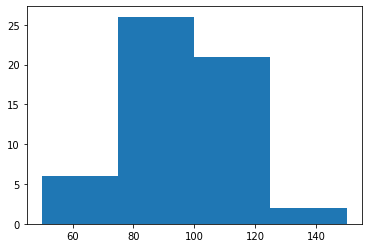

In [ ]:
res3 = spark.sql("""
SELECT id, cast(value as int) as length
FROM titledetail
WHERE property = 'LD length'
ORDER by length desc
""")
res3.show(5)

t = res3.collect()
tab = [x.length for x in t]
plt.hist(tab, bins = [50,75,100,125,150])
plt.show()

#### Titres de films dont on connait l'indication de couleur ou de N&B

In [ ]:
%sql 
create or replace temp view title_with_color as
select id, title, value as Color_or_BW
from TitleDetail
where property = 'color info'
;

select * from title_with_color;

id title Color_or_BW 3342 106 & Park Top 10 Live Color 3981 Ärzte für Südafrika Color 9005 Day 8: 7:00 p.m.-8:00 p.m. Color 9376 (#1.36) Color 12020 (#1.13) Color 14092 (#1.7) Color 19610 Hello, Goodbye, Amen Color 21133 Coming Ready or Not: Part 1 Color 21216 Fallen Idols: Part 2 Color 21871 Things of Value: Part 1 Color 21964 Wings: Part 2 Color 22983 (#1.40) Color 25679 The Third Person Black and White 26805 A Place by the Sea Color 31117 A Última Semana Color 32231 Boys Will Be Boys Color 34353 Abenteuer Zoo Color 37369 The Turkey Bowl Color 38999 Actors en primer pla Color 40858 The Search Color 42903 Rokovoye vlecheniye Color 45694 (#1.18) Color 48314 (#1.37) Color 50062 Análisis con sorpresa Color 50459 Falso culpable Color 50634 La trampa Color 51007 Teatro en la nevera Color 52038 God natt och sov gott Color 54523 Mother-in-Law: Part 2 Color 55789 (#1.10013) Color 56253 (#1.10477) Color 57586 (#1.9746) Color 59692 All Time Greatest Bloopers Color 59712 Computer Games Color 59975 How to Marry a Muslim Color 62975 Eva florecida Color 70071 Bighorn Otaku Color 70568 Ben Bradley Killer Color 73104 First Half Final Round: Petitto vs. Phillips/Williams vs. Hutson Color 74550 Directed by William Wyler Black and White 74550 Directed by William Wyler Color 75086 Dottie Color 75484 American Weed Color 76695 (#1.21) Color 78022 An Evening at Home with Bernard Braden and Barbara Kelly Black and White 82333 (#7.21) Color 83387 Animal Cops: San Francisco Color 85610 O Magazine Cookbook Color 86268 A Gal for Grandma Black and White 87411 (1995-05-25) Color 88256 (1998-12-07) Color 88661 (2000-01-21) Color 89007 (2001-01-07) Color 89549 (2002-07-15) Color 89862 (2003-12-28) Color 90915 Indonesia Color 92127 Rebel with a Cause Color 93326 The Applicant Color 99302 Tunnel to Freedom Black and White 107616 De Midasmoorden Color 114708 Australia's Worst Driver Color 116500 Aventuras Vascas Color 120158 Baaghe Mozaffar Color 121444 Bentley's Economy Wave Black and White 121734 (#1.24) Color 124256 The Psychic and the C-Cup Color 124831 Balash Be-Yerushalayim Color 124945 Balikabayan Color 125343 Hello and Farewell Color 126116 Bandeira 2 Black and White 126994 Banegi Apni Baat Color 129745 A Dangerous Affair Color 129901 The Price of Terror Color 130582 Barter Up! Color 133860 The Swimmer Color 135912 The Bridge Black and White 135946 The Exiles #2: The Long Summer Black and White 136133 When in Rome Black and White 138164 (#1.81) Color 138436 Beautiful You HDTV Color 138917 Gamen Color 141781 Beit Sefer Chagavim Color 142053 (#1.121) Color 142175 (#1.70) Color 143366 Of All Save Pain Bereft Black and White 143855 Flight of the Dodo: Part 2 Color 148267 Judgement Day Color 148367 The Final Proof Color 155434 Gang Leader Black and White 155963 Bij Dorus op visite Black and White 162224 Client: Frome Black and White 164559 Rachel Loring vs Sean Redshaw and Paul Mason Color 165757 Collateral Damage Color 166024 A Little Faith Color 166470 Those That Trespass Color 166474 Too Good to Be True: Part 2 Color 172170 Bonjour la France Color 173522 Reelin' in the Years Color 185239 The Comet Color 186565 Lives in the Balance Color 186801 Get Me Cody Swift Color 189567 Misiones, Argentina Color 192280 Böttinger Color 192293 Børneafdelingen Color 196143 Blue Water, White Beach Black and White 198974 En medio de la noche Color 202528 Canada's Super Speller Color 202976 Canarias Noticias Color 205966 (#1.127) Color 206068 (#1.219) Color 206941 Caroline and the Perfect Record Color 211519 Shipwrecked! Color 212346 Hide and Seek Color 212452 Love and Duty Color 212603 Remembrance Color 214092 (#3.3) Black and White 216018 Puppetman Color 217158 Cedomir Ilic Black and White 217477 (2004-06-23) Color 217480 A Missão de Hugo Color 217936 Celebrity Countdown Color 221636 El secreto de Nico Color 221664 Mercedes tras las pistas Color 221700 ¡Gonzalo para Colombia! Color 222776 Swing for the Moon Black and White 223010 Chapi-Chapo Color 223012 Chappelle's Show

#### Movie Rentals

Movie_rentals(id, title, rental_value, currency, country)

In [ ]:
%sql
create or replace temp view Movie_rentals as
select id, title, 
regexp_extract(value, '(.)([0-9,]+)( \\((.+)\\))*', 2) as rental_value,
regexp_extract(value, '(.)([0-9,]+)( \\((.+)\\))*', 1) as currency,
regexp_extract(value, '(.)([0-9,]+)( \\((.+)\\))*', 4) as country
from TitleDetail
where property = 'rentals'
;

select *
from Movie_rentals;

id title rental_value currency country 1666737 Adventure 4,236,000 $ USA 1714929 Basic Instinct 53,000,000 $ USA 1714929 Basic Instinct 8,500,000 £ UK 1763216 Catch-22 12,250,000 $ USA 1776735 Circle of Iron 1,000,000 $ USA 1875462 European Vacation 25,600,000 $ USA 2351874 The Bowery 1,494,294 $ USA 2388912 The Love Bug 23,150,000 $ USA 2082136 Looking for Mr. Goodbar 16,900,000 $ 1833314 Diner 4,000,000 $ USA 2409929 The Saint 28,227,120 $ USA 2290713 Sisters 1,000,000 $ USA

####  date de début et fin de tournage 

Title_filming_date(id, title, start_date, end_date)

In [ ]:
%sql -- Cinquième table de
create or replace temp view title_filming_date as
select id, title,
trim(regexp_extract(value, '([^-]*)', 1)) as Start_date,
trim(regexp_extract(value, '[^-]*-(.*)', 1)) as Ending_date
from titleDetail
where property = 'filming dates'
;

select *
from title_filming_date;

id title Start_date Ending_date 216018 Puppetman 17 April 1987 308987 Planning Meetings January 2010 13 January 2010 20 January 2010 517511 Genie Swap 29 June 2007 26 September 2007 550835 Grillen 28 May 2012 30 May 2012 575345 Pass the Parcel 24 April 2009 1280982 The Beatles Anthology 23 June 1994 23 June 1994 1326752 Pretty Babies 17 February 1981 (script taping date) 1602432 (#1.3) 19 October 1994 19 October 1994 1640436 3.14... 2 April 2011 1640924 38 premios Sant Jordi de Cinematografía 30 May 1994 30 May 1994 1643546 9 1/2 Ninjas! 26 March 1990 12 April 1990 1654259 A Nightmare on Elm Street: The Dream Child 7 April 1989 ? 1658722 A Thin Line Between Love and Hate 5 June 1995 11 August 1995 1665018 Action Hero 2008 ? 1666737 Adventure May 1945 September 1945 1674408 Alice in Storageland 15 March 2004 ? 1677488 Almada-Negreiros: Vivo, Hoje June 1969 June 1969 1681229 American Judy 19 March 2012 1691331 Ants in the Pantry 11 December 1935 14 December 1935 1692359 Apocalyptic Adventure on the Eastern Frontier 7 May 2000 14 May 2000 1707602 Bachelor Mother 6 March 1939 29 April 1939 1714929 Basic Instinct 5 April 1991 10 September 1991 1723692 Betsy's Wedding 16 October 1989 30 December 1989 1733034 Black Sky 23 July 2012 28 September 2012 1745294 Breathing Room December 1994 1759662 Capulina corazón de leon 8 April 1968 30 April 1968 1763216 Catch-22 13 January 1969 August 1969 1768031 Charlie Chan in Reno 23 January 1939 24 February 1939 1770926 Chicago Joe and the Showgirl 10 July 1989 25 August 1989 1778331 Class of 1999 II: The Substitute April 1993 1791850 Crash 27 September 1995 10 December 1995 1792571 Creation of the Humanoids: Green Screen Test 8 September 2007 9 September 2007 1797249 Curly Sue 14 November 1990 23 March 1991 1810763 De-Lovely 5 May 2003 ? 1818657 Der Hauptdarsteller 15 February 1977 28 March 1977 1820899 Der Tanz auf dem Vulkan 21 May 1938 August 1938 1825067 Devil's Tree 20 September 2013 15 December 2013 1826689 Diciotto anni dopo May 2009 June 2009 1827911 Die Entführung aus dem Serail 23 June 2003 23 June 2003 1837200 Doble sesión September 2010 1848433 Duffy's Irish Circus 10 June 1998 26 December 2005 1860888 El miedo no anda en burro 26 February 1973 27 March 1973 1868924 Enemies Closer 11 June 2012 7 July 2012 1871251 Erased James Franco 8 July 2008 8 July 2008 1875462 European Vacation September 1984 December 1984 1901779 Frau im Mond October 1928 June 1929 1917396 Gigi 9 October 1948 30 December 1948 1918459 Girl Walks Into a Bar 23 February 2010 6 March 2010 1930940 GumptionFest 4 September 2009 8 September 2009 1954999 Hollywoodland 2 May 2005 ? 1957593 Hope Springs 15 October 2001 January 2002 1965593 Hämnaren 19 April 1915 5 May 1915 1994614 Jackson Arms 6 July 2006 21 July 2006 2023127 Knights 8 June 1992 3 July 1992 2026642 Krantz 17 January 2009 25 January 2009 2034101 L'influence d'un trésor 4 June 2005 7 June 2005 2050179 La última boda 6 November 2008 12 November 2008 2053175 Lars and the Real Girl November 2006 ? 2055097 Late December 5 January 2010 19 January 2010 2057920 Le congrès des belles-mères 8 June 1954 3 August 1954 2062042 Le salaire du péché 16 January 1956 10 March 1956 2062658 Le temps de vivre 16 April 1968 22 June 1968 2066754 Les chats bottés 20 October 1970 4 December 1970 2082605 Lord of the Flies 22 August 1988 September 1988 2099290 Mammoth 5 November 2007 ? 2100576 Manege June 1937 ? 2113622 Menschen unter Haien 1942 2115422 Metropolis Underground 11 November 2009 15 December 2009 2134379 Mujeres sin mañana 5 April 1951 ? 2135290 Murder Blues 3 July 1990 9 August 1990 2136673 Mutiny 15 June 1951 July 1951 2137707 My Darling Clementine 1 April 1946 June 1946 2154239 Nightmare (30 days) 2157308 No Place Like Jail 1 July 1918 5 July 1918 2157308 No Place Like Jail 12 July 1918 (retakes) 2159811 Norsk 18 February 2009 8 March 2009 2168956 Oechul 4 February 2005 ? 2196189 Pekka ja Pätkä salapoliiseina August 1957 November 1957 2223461 Puppetmaster 1 December 

#### réorganiser ces dates par jour, mois et année de début et fin de tournage

Title_filming_date (id, title, start_day, start_month, start_year, end_day, end_month, end_year)

In [ ]:
%sql 
--create or replace temp view title_filming_date as
select id, title, 
regexp_extract(Start_date, '^([0-9]{1,2})[^0-9]', 1) as Starting_day,
regexp_extract(Start_date, '[^a-zA-Z]*([a-zA-Z]*) [0-9]', 1) as Starting_Month,
regexp_extract(Start_date, '[^a-zA-Z]*[a-zA-Z ]*([0-9]{4})', 1) as Starting_Year,
regexp_extract(Ending_date, '^([0-9]{1,2})[^0-9]', 1) as Ending_day,
regexp_extract(Ending_date, '[^a-zA-Z]*([a-zA-Z]*) [0-9]', 1) as Ending_Month,
regexp_extract(Ending_date, '[^a-zA-Z]*[a-zA-Z ]*([0-9]{4})', 1) as Ending_Year

from title_filming_date
;

--select * from title_filming_date;

id title Starting_day Starting_Month Starting_Year Ending_day Ending_Month Ending_Year 216018 Puppetman 17 April 1987 308987 Planning Meetings January 2010 13 January 2010 20 January 2010 517511 Genie Swap 29 June 2007 26 September 2007 550835 Grillen 28 May 2012 30 May 2012 575345 Pass the Parcel 24 April 2009 1280982 The Beatles Anthology 23 June 1994 23 June 1994 1326752 Pretty Babies 17 February 1981 1602432 (#1.3) 19 October 1994 19 October 1994 1640436 3.14... 2 April 2011 1640924 38 premios Sant Jordi de Cinematografía 30 May 1994 30 May 1994 1643546 9 1/2 Ninjas! 26 March 1990 12 April 1990 1654259 A Nightmare on Elm Street: The Dream Child 7 April 1989 1658722 A Thin Line Between Love and Hate 5 June 1995 11 August 1995 1665018 Action Hero 2008 1666737 Adventure May 1945 September 1945 1674408 Alice in Storageland 15 March 2004 1677488 Almada-Negreiros: Vivo, Hoje June 1969 June 1969 1681229 American Judy 19 March 2012 1691331 Ants in the Pantry 11 December 1935 14 December 1935 1692359 Apocalyptic Adventure on the Eastern Frontier 7 May 2000 14 May 2000 1707602 Bachelor Mother 6 March 1939 29 April 1939 1714929 Basic Instinct 5 April 1991 10 September 1991 1723692 Betsy's Wedding 16 October 1989 30 December 1989 1733034 Black Sky 23 July 2012 28 September 2012 1745294 Breathing Room December 1994 1759662 Capulina corazón de leon 8 April 1968 30 April 1968 1763216 Catch-22 13 January 1969 August 1969 1768031 Charlie Chan in Reno 23 January 1939 24 February 1939 1770926 Chicago Joe and the Showgirl 10 July 1989 25 August 1989 1778331 Class of 1999 II: The Substitute April 1993 1791850 Crash 27 September 1995 10 December 1995 1792571 Creation of the Humanoids: Green Screen Test 8 September 2007 9 September 2007 1797249 Curly Sue 14 November 1990 23 March 1991 1810763 De-Lovely 5 May 2003 1818657 Der Hauptdarsteller 15 February 1977 28 March 1977 1820899 Der Tanz auf dem Vulkan 21 May 1938 August 1938 1825067 Devil's Tree 20 September 2013 15 December 2013 1826689 Diciotto anni dopo May 2009 June 2009 1827911 Die Entführung aus dem Serail 23 June 2003 23 June 2003 1837200 Doble sesión September 2010 1848433 Duffy's Irish Circus 10 June 1998 26 December 2005 1860888 El miedo no anda en burro 26 February 1973 27 March 1973 1868924 Enemies Closer 11 June 2012 7 July 2012 1871251 Erased James Franco 8 July 2008 8 July 2008 1875462 European Vacation September 1984 December 1984 1901779 Frau im Mond October 1928 June 1929 1917396 Gigi 9 October 1948 30 December 1948 1918459 Girl Walks Into a Bar 23 February 2010 6 March 2010 1930940 GumptionFest 4 September 2009 8 September 2009 1954999 Hollywoodland 2 May 2005 1957593 Hope Springs 15 October 2001 January 2002 1965593 Hämnaren 19 April 1915 5 May 1915 1994614 Jackson Arms 6 July 2006 21 July 2006 2023127 Knights 8 June 1992 3 July 1992 2026642 Krantz 17 January 2009 25 January 2009 2034101 L'influence d'un trésor 4 June 2005 7 June 2005 2050179 La última boda 6 November 2008 12 November 2008 2053175 Lars and the Real Girl November 2006 2055097 Late December 5 January 2010 19 January 2010 2057920 Le congrès des belles-mères 8 June 1954 3 August 1954 2062042 Le salaire du péché 16 January 1956 10 March 1956 2062658 Le temps de vivre 16 April 1968 22 June 1968 2066754 Les chats bottés 20 October 1970 4 December 1970 2082605 Lord of the Flies 22 August 1988 September 1988 2099290 Mammoth 5 November 2007 2100576 Manege June 1937 2113622 Menschen unter Haien 1942 2115422 Metropolis Underground 11 November 2009 15 December 2009 2134379 Mujeres sin mañana 5 April 1951 2135290 Murder Blues 3 July 1990 9 August 1990 2136673 Mutiny 15 June 1951 July 1951 2137707 My Darling Clementine 1 April 1946 June 1946 2154239 Nightmare 2157308 No Place Like Jail 1 July 1918 5 July 1918 2157308 No Place Like Jail 12 July 1918 2159811 Norsk 18 February 2009 8 March 2009 2168956 Oechul 4 February 2005 2196189 Pekka ja Pätkä salapoliiseina August 1957 November 1957 2223461 Puppetmaster 1 December 1988 2

#### Role H/F
nombre d'H et de F par profession, 
pourcentage H F par profession

RoleHF(role, nbH, nbF, Hpct, Fpct)